**Author:** [Kevin ALBERT](https://github.com/albert-kevin)  
**Created:** Started June 2022  
  
**Discord Channel:** [IOG's Technical Community](https://discord.gg/QWqJF9cMzV)  
  
**Discord - Plutus Pioneers 3rd Cohort classmate:** [Marco Martins - [HYPE] Pool](https://github.com/marco-martins) & [gists](https://gist.github.com/marco-martins)  
**Discord - marlowe-cli and technical questions:** [Brian W Bush - IOG](https://github.com/bwbush)  
**Discord - keys, wallets, cardano-cli:** [George - [APEX] Pool](https://github.com/cardano-apexpool) & [gists](https://gist.github.com/cardano-apexpool)  
**Discord - Marlowe typescript SDK and technical questions:** [Tomasz Rybarczyk - IOG](https://github.com/paluh)  
**Discord - Marlowe typescript SDK:** [Nick Stanford - IOG](https://github.com/nstanford5)  
  
**AI Assistant:** [ChatGPT - OpenAI v4](https://openai.com/)  
**Visualisations:** [Miro designs](https://miro.com/app/board/uXjVP3tf9_E=/?moveToWidget=3458764542137977013&cot=14) and [Replicate](https://replicate.com/ai-forever/kandinsky-2.2)  

In [1]:
import datetime, time
print ('Last run: ' + datetime.datetime.now().strftime("%d %b %Y (%H:%M CET)"))

Last run: 09 Apr 2024 (16:58 CET)


# Smart Contract 
_**how to deploy a custom financial contract**_

## Contents
1. [Objective](#Objective)
   - [tools](#tools)
   - [network](#network)
   - [contract templates](#contract-templates)
1. [Installation](#Installation)
   - [python](#python)
   - [versions](#versions)
   - [modules](#modules)
   - [server](#server)
   - [software](#software)
   - [cardano tools](#cardano-tools)
   - [setup environment](#setup-environment)
   - [helper function](#helper-function)
   - [start services](#start-services)
   - [socket](#socket)
1. [Roadmap](#Roadmap)
1. [Wallet](#Wallet)
   - [generating keys](#generating-keys)
   - [generating address](#generating-address)
1. [Contract](#Contract)
   - [code javascript](#code-javascript)
   - [code marlowe](#code-marlowe)
   - [code blockly](#code-blockly)
1. [Funding](#Funding)
   - [funds wallet](#funds-wallet)
   - [create wallet 1-2](#create-wallet-1-2)
   - [transfer funds](#transfer-funds)
1. [Parameters](#Parameters)
   - [time](#time)
1. [Tokens](#Tokens)
   - [token metadata](#token-metadata)
   - [token minting](#token-minting)
1. [Transactions](#Transactions)
   - [modify contract parameters](#modify-contract-parameters)
   - [tx#1 start contract](#transaction-#1-start-contract-(3-ADA))
   - [tx#2 first deposit](#transaction-#2-first-deposit-(200-ADA))
   - [tx#3 second deposit](#transaction-#3-second-deposit-(100-ADA))
   - [tx#4-5 end contract](#transaction-#4-and-#5-contract-ended-(withdraw))
1. [Deployment](#Deployment)
1. [Cleanup](#Cleanup)


## Objective

The objective of this reference guide is to share and demonstrate what was learned  
during the Marlowe Pioneer Program (Summer 2022) on how to run custom financial smart contracts  
on the blockchain using <b class="ttooltip">Marlowe<span class="tooltiptext">a domain-specific language (DSL) built on Plutus that is used to write smart contracts for financial applications. It aims to make it easy for non-technical users to write smart contracts for financial applications such as crowdfunding, escrow, and lending.</span></b>. This guide will show how to use Python and other modules  
in conjunction with Cardano script command tools to implement smart contracts on the blockchain.

### tools

This notebook will use all these commands:
    
    cardano-node run                               Run the node
    
    cardano-wallet serve                           Serve API that listens for commands/actions
    cardano-wallet recovery-phrase generate        Generate an English recovery phrase
    cardano-wallet key from-recovery-phrase        Convert a recovery phrase to an extended private key
    
    cardano-cli key convert-cardano-address-key    Convert a cardano-address extended signing key to a Shelley-format key
    cardano-cli key verification-key               Get a verification key from a signing key, supports all key types
    cardano-cli address build                      Build a Shelley payment address, optional delegation to a stake address
    cardano-cli query tip                          Get the node's current tip (slot no, hash, block no)
    cardano-cli query utxo                         Get a portion of the current UTxO: by tx in, by address or the whole
    
    marlowe-cli template swap                      Create a swap contract
    marlowe-cli util slotting                      Find the slot-to-time relationship for the current epoch
    marlowe-cli util mint                          Mint native tokens
    marlowe-cli util clean                         Reorganize the UTxOs at an address, separating tokens
    marlowe-cli transaction simple                 Build a non-Marlowe transaction
    marlowe-cli run initialize                     Init first transaction of Marlowe contract and write a JSON file
    marlowe-cli run execute                        Run a Marlowe transaction
    marlowe-cli run auto-execute                   Run a Marlowe transaction, selecting tx inputs and outputs automatically
    marlowe-cli run prepare                        Prep next step of a Marlowe contract and write a JSON file
    marlowe-cli run withdraw                       Withdraw funds from the Marlowe role address
    marlowe-cli util fund-address                  fund addresses from a source wallet
    marlowe-cli run analyze                        analyze a generated Marlowe contract

### network
Due to the Marlowe-pioneer blockchain testnet being offline since December 2022 (NetworkMagic: 1567),  
we will be using a different testnet for our purposes.  

For information on the available Cardano blockchain network environments,  
please visit the following resources:
* **[developers.cardano.org](https://developers.cardano.org/docs/get-started/running-cardano/#cardano-blockchain--nets)**
* **[book.world.dev.cardano.org](https://book.world.dev.cardano.org/environments.html)** (find usage, epoch length and cardano-node compatible version)
* **[github.com environments](https://github.com/input-output-hk/cardano-world/tree/master/docs/environments)** (find protocolMagic in "byron-genesis.json")

Here are some Networks available:  
* **testnet**
  * <span style="color: green;">preprod</span> (NetworkMagic: 1)
  * <span style="color: green;">**preview**</span> (NetworkMagic: **2**)
  * <span style="color: green;">sanchonet</span> (NetworkMagic: 4)
* **production**
  * <span style="color: green;">mainnet</span> (NetworkMagic: 764824073)
* **development** (throw-away)
  * <span style="color: red;"><s>pv8</s></span> (NetworkMagic: 6)
  * <span style="color: red;"><s>vasil-dev</s></span> (NetworkMagic: 9)
* **legacy** (internal-only)
  * <span style="color: red;"><s>shelley-qa</s></span> (NetworkMagic: 3)
  * <span style="color: red;"><s>staging</s></span> (NetworkMagic: 633343913)
  * <span style="color: red;"><s>testnet</s></span> (NetworkMagic: 1097911063)

In this notebook, we will be using the <b class="ttooltip">PREVIEW<span class="tooltiptext">A preview testnet is a testing version of the blockchain for experimenting and debugging before going live on mainnet. It has a 1-day epoch, leads mainnet hard forks by at least 4 weeks and it is intended for developers and users to test without risk before live deployment.</span></b> Cardano blockchain network with MAGIC **2**.

### contract templates
In the near future, anticipate projects that will enrich the ecosystem with thoroughly audited, widely adopted contract frameworks.  
These will feature mechanisms for evaluating creator reputation and contract trustworthiness,  
fostering a community-driven marketplace for sharing and reusing financial code.  
Imagine contributing to this evolving landscape. However, in this notebook,  
we focus on the practical application of current templates, particularly on deploying a simple contract.  
  * **[Actus](https://github.com/input-output-hk/marlowe-cardano/tree/main/marlowe-cli/examples/actus)** - A zero-coupon bond contract where one party borrows and the other party pays back with interest
  * **[CFD](https://github.com/input-output-hk/marlowe-cardano/tree/main/marlowe-cli/examples/cfd)** - A contract for differences where two parties settle for price differences
  * **[Covered Call](https://github.com/input-output-hk/marlowe-cardano/tree/main/marlowe-cli/examples/coveredCall)** - A contract that transfers a token if the counter-party exercises the option
  * **[Escrow](https://github.com/input-output-hk/marlowe-cardano/tree/main/marlowe-cli/examples/escrow)** - A contract that facilitates the purchase of an item at a price agreed upon by the buyer and seller with a mediator
  * **[Simple](https://github.com/input-output-hk/marlowe-cardano/tree/main/marlowe-cli/examples/simple)** - A contract that takes a deposit, waits for a notification, and makes a payment
  * **[Swap](https://github.com/input-output-hk/marlowe-cardano/tree/main/marlowe-cli/examples/swap)** - A contract that allows two parties to exchange native tokens
  
With our focus on a **swap** contract, we'll demonstrate the process of deploying a foundational financial contract on the Cardano blockchain,  
paving the way for you to understand future innovations.  
  
A swap contract on the Cardano blockchain allows users to exchange one cryptocurrency for another  
without the need for a centralized exchange. The contract automatically executes the trade  
when both parties have fulfilled their end of the agreement.  

## Installation

### python

Create and activate a new conda environment: 
```sh
/anaconda/bin/conda create -y --name py39_cardano python=3.9
/anaconda/bin/conda activate py39_cardano
```

Install additional packages:
```sh
pip install -U ipykernel psutil requests pandas
```

In [2]:
# # create a new conda environment "py39_cardano" then reload this notebook
# ! /anaconda/bin/conda create -y --name py39_cardano python=3.9

In [3]:
# # install additional packages
# ! /anaconda/envs/py39_cardano/bin/python -m pip install -U ipykernel psutil requests pandas

### versions

In [4]:
# installed modules in python
conda_version = ! conda -V
print(f"conda       : {conda_version[0].split()[1]}")
pip_version = ! pip -V
print(f"pip         : {pip_version[0].split()[1]}")
python_version = ! python -V
print(f"python      : {python_version[0].split()[1]}")
pandas_version = ! pip list |grep -i pandas
print(f"pandas      : {pandas_version[0].split()[1]}")
numpy_version = ! pip list |grep -i numpy
print(f"numpy       : {numpy_version[0].split()[1]}")
requests_version = ! pip list |grep -i requests
print(f"requests    : {requests_version[0].split()[1]}")

conda       : 4.12.0
pip         : 21.2.4
python      : 3.9.12
pandas      : 1.4.3
numpy       : 1.23.0
requests    : 2.28.0


### modules

In [5]:
# used for loading a webpage
from IPython.display import Javascript # allow to load a website in a new browser tab
from IPython.display import SVG        # allow to load interactive linked images
from IPython.core.display import HTML

import re           # regex tool
import pandas as pd # tabular data tool
import numpy as np  # needed for helper function
import json         # json data structure tool
import requests     # standard for making HTTP requests
import datetime     # manipulating and formatting dates and times

# environment packages
import platform
import psutil
import os

# https://stackabuse.com/executing-shell-commands-with-python/
import subprocess

# pd.describe_option('display')            # show all pandas options, parameters can slow down notebook
pd.set_option('display.max_colwidth', 80)  # default 50, the maximum width in characters of a column
pd.set_option('display.max_columns', 20)   # default 20, the maximum amount of columns in view 
pd.set_option('display.max_rows', 60)      # default 60, the maximum amount of rows in view

In [6]:
# setup a mouse over tooltip feature
def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """
   styles = open(css_file_path, "r").read()
   st = '<style>%s</style>' % styles     
   return HTML(st)

# custom style code
_set_css_style('../scripts/tooltip_style.css')

### server
This notebook operates on an Azure IaaS server, specifically using a **Standard_A8m_v2** size virtual machine.  
I've opened multiple ports for diverse services like:  
 * 22 (SSH terminal)
 * 80 (HTTP)
 * 8000 (jupyter notebooks)
 * 8090 (cardano-wallet)
 * 8050 (web-server)  

In [7]:
# Virtual Machine environment 
print(f"Cores : {psutil.cpu_count(logical=True)} ({psutil.cpu_freq().current/1000:.0f}GHz)")
print(f"Memory: {psutil.virtual_memory().total/(1024**3):.2f} GB ({psutil.virtual_memory().percent:.0f}% used)")
print(f"Swap  : {os.path.getsize('/swapfile')/(1024**3):.0f} GB")
disk_size = psutil.disk_usage(psutil.disk_partitions()[0].mountpoint).total
disk_used = psutil.disk_usage(psutil.disk_partitions()[0].mountpoint).percent
disk_fs   = psutil.disk_partitions()[0].fstype 
print(f"Disk  : {disk_size/(1024**3):.0f} GB {disk_fs} ({disk_used:.0f}% used)")
print(f"System: {platform.uname().version.split('~')[1].split()[0]}")

Cores : 8 (3GHz)
Memory: 62.80 GB (12% used)
Swap  : 8 GB
Disk  : 242 GB ext4 (77% used)
System: 20.04.1-Ubuntu


In [8]:
# current user's home directory path (~)
!echo $HOME

/home/ubuntu


### software
Connect to your VM using a Terminal (Putty).  
**Update** your installation.  
Install **curl** and **rsync**.  
```sh
sudo sh -c 'apt update && apt install curl rsync'
```  

Install <b class="ttooltip">Z3<span class="tooltiptext">an open-source theorem prover from Microsoft Research, designed for verifying smart contract JSON files to ensure they are free from duplicates, invalid values and within parameter boundaries.</span></b> a dependency used by `marlowe-cli run analyze` for analyzing smart contract safety of contract execution.  
```sh
sudo sh -c 'apt install -y z3'
```  
---
**Install nixos** from the official installation script.  
Nixos is a form of virtual environment like docker with cryptographic hashed package manager Nix to eliminate dependency hell.
```sh
sh <(curl -L https://nixos.org/nix/install) --daemon
```
---
Adding these configurations to **nix.conf** and **restart** the nix-daemon  
enhances the build process for NixOS by utilizing pre-compiled, trusted binaries.  
This approach significantly accelerates the setup by eliminating the need to compile from scratch.  
```sh
sudo sh -c "echo 'substituters = https://cache.nixos.org https://cache.iog.io' >> /etc/nix/nix.conf"
sudo sh -c "echo 'trusted-public-keys = hydra.iohk.io:f/Ea+s+dFdN+3Y/G+FDgSq+a5NEWhJGzdjvKNGv0/EQ= cache.nixos.org-1:6NCHdD59X431o0gWypbMrAURkbJ16ZPMQFGspcDShjY=' >> /etc/nix/nix.conf"
sudo sh -c "echo 'experimental-features = nix-command' >> /etc/nix/nix.conf"  
sudo sh -c "echo 'extra-experimental-features = flakes' >> /etc/nix/nix.conf"  
sudo sh -c 'echo "trusted-users = $0" >> /etc/nix/nix.conf' `whoami`
```

**source (github marlowe-cardano): [How to set up the IOG binary caches](https://github.com/input-output-hk/marlowe-cardano#nix-1)**  
**source (github cardano-node): [How to set up the IOG binary caches](https://github.com/input-output-hk/cardano-node-wiki/blob/main/docs/getting-started/building-the-node-using-nix.md)**  

In [9]:
# here is the content of the 'nix.conf' file
!cat /etc/nix/nix.conf

substituters = https://cache.nixos.org https://cache.iog.io
trusted-public-keys = hydra.iohk.io:f/Ea+s+dFdN+3Y/G+FDgSq+a5NEWhJGzdjvKNGv0/EQ= cache.nixos.org-1:6NCHdD59X431o0gWypbMrAURkbJ16ZPMQFGspcDShjY=
experimental-features = nix-command
extra-experimental-features = flakes
trusted-users = ubuntu
build-users-group = nixbld


Restart Nix  
```sh
sudo systemctl restart nix-daemon.service
```

In [10]:
# installed version of Nix package manager system
!/nix/var/nix/profiles/default/bin/nix --version

nix (Nix) 2.12.0


### cardano tools
We want to stay updated with the latest official Cardano software versions and ensure compatibility.  
**As this notebook might become outdated, it's crucial to periodically check for new releases.**  
Dependency issues may restrict immediate updates to the latest versions, but the demonstrated version is confirmed functional.  

In [11]:
# check the latest available versions from Github
response = requests.get("https://api.github.com/repos/input-output-hk/cardano-wallet/releases/latest")
print(f'cardano-wallet\t\t: {response.json()["tag_name"]}')
response = requests.get("https://api.github.com/repos/IntersectMBO/cardano-node/releases/latest")
print(f'cardano-node \t\t: {response.json()["tag_name"]}')
response = requests.get("https://api.github.com/repos/input-output-hk/marlowe-cardano/releases/latest")
print(f'marlowe-runtime  \t: {response.json()["tag_name"]}')
# List all marlowe assets
assets = response.json().get('assets', [])
for asset in assets:
    print(f"\t\t\t  + {asset['name']}")

cardano-wallet		: v2024-03-27
cardano-node 		: 8.9.1
marlowe-runtime  	: runtime@v0.0.6
			  + marlowe-cli
			  + marlowe-finder
			  + marlowe-oracle
			  + marlowe-pipe
			  + marlowe-runtime-cli
			  + marlowe-scaling
			  + marlowe-streamer
			  + signing-service


Install <b class="ttooltip">cardano-wallet<span class="tooltiptext">It allows users to create and manage multiple wallets, each with its own set of private keys to sending and receive ADA, as well as viewing their transaction history and current balance.</span></b> by downloading version **v2024-03-27** from Github,  
extract the downloaded package and cleanup.  
**[click here](https://github.com/input-output-hk/cardano-wallet/releases/latest)** to check the latest cardano-wallet version.  
```sh
cd ~/cardano
wget https://github.com/input-output-hk/cardano-wallet/releases/download/v2024-03-27/cardano-wallet-v2024-03-27-linux64.tar.gz
tar xzf cardano-wallet-v2024-03-27-linux64.tar.gz
rm cardano-wallet-v2024-03-27-linux64.tar.gz
mv cardano-wallet-v2024-03-27-linux64/* ~/cardano/
rm -Rf cardano-wallet-v2024-03-27-linux64
```
if you **update**,
```sh
# follow the documentation for special situations to preserve your wallets, I will remove and reinstall
cd ~/cardano
rm -Rf auto-completion
rm -Rf wallet-db
# reinstall
```
disable **IPv6** warning errors (NTP client experienced error Network.Socket.ByteString.SendManyTo:)
```sh
sudo sh -c "echo 'net.ipv6.conf.all.disable_ipv6 = 1' >> /etc/sysctl.conf"
sudo sh -c "echo 'net.ipv6.conf.default.disable_ipv6 = 1' >> /etc/sysctl.conf"
sudo sh -c "echo 'net.ipv6.conf.lo.disable_ipv6 = 1' >> /etc/sysctl.conf"
# apply your changes
sudo sysctl -p
# verify if output is `1` = `disabled`
cat /proc/sys/net/ipv6/conf/all/disable_ipv6
```
---
Install <b class="ttooltip">cardano-node<span class="tooltiptext">a Cardano node is responsible for maintaining and updating the state of the Cardano blockchain, which allows it to function as a decentralized network.</span></b> by downloading version **8.9.1** from GitHub,  
creating a new directory, extract the downloaded package and cleanup.  
**[click here](https://github.com/IntersectMBO/cardano-node/releases/latest)** to check the latest cardano-node version.  
```sh
mkdir ~/cardano
cd ~/cardano
wget https://github.com/IntersectMBO/cardano-node/releases/download/8.9.1/cardano-node-8.9.1-linux.tar.gz
tar xzfv cardano-node-8.9.1-linux.tar.gz --wildcards --strip-components=2 './bin/*'
rm cardano-node-8.9.1-linux.tar.gz
```
if you **update**, the binary gets overwritten, the cached blockchain data will sync when you run it.  

---
Download <b class="ttooltip">marlowe-cli <span class="tooltiptext">It allows developers to write, test, and deploy smart contracts written in Marlowe to the Cardano network.</span></b> (version **0.2.0.0**) as part of the Marlowe Runtime package **v0.0.6** from GitHub,  
Download <b class="ttooltip">marlowe-runtime-cli <span class="tooltiptext">It allows developers to write, test, and deploy smart contracts written in Marlowe to the Cardano network with a focused on post-deployment activities, such as managing live contracts and facilitating interactions between users and deployed contracts.</span></b> as part of the Marlowe Runtime package **v0.0.6** from GitHub,  
same commands if you **update**  
**[click here](https://github.com/input-output-hk/marlowe-cardano/tree/main/marlowe-cli)** to check the latest marlowe-cli git repo.  
##### setup & cleanup
```sh
# clearing the Nix cache to free up space
nix-store --gc  
# removing unused packages for a cleaner system
nix-collect-garbage -d
# deleting old marlowe-cardano directory to avoid conflicts
sudo rm -Rf marlowe-cardano
# cleaning up software packages no longer needed
sudo apt-get autoremove
```
##### download & install
```sh
# clone the marlowe-cardano repository
git clone https://github.com/input-output-hk/marlowe-cardano
cd marlowe-cardano
# ensure you're on the correct git version
git checkout tags/runtime@v0.0.6

# navigate to marlowe-cli and start/build Nix development environment
cd marlowe-cli
nix develop
# Note: installation takes some time (~1 hour), be patient!

# for custom setups, manually copy necessary files to specific locations
sudo mkdir -p /nix/store/xlz0iq3afc917irlpkgniwnyzc29h079-marlowe-cardano-lib-marlowe-cardano-x86_64-unknown-linux-musl-0.2.1.0-data/share/x86_64-unknown-linux-musl-ghc-9.2.8/x86_64-linux-ghc-9.2.8/marlowe-cardano-0.2.1.0-KUM9ERSqB1TBIgHUrLPrQ3/scripts

sudo cp marlowe-cardano/marlowe/scripts/*.plutus /nix/store/xlz0iq3afc917irlpkgniwnyzc29h079-marlowe-cardano-lib-marlowe-cardano-x86_64-unknown-linux-musl-0.2.1.0-data/share/x86_64-unknown-linux-musl-ghc-9.2.8/x86_64-linux-ghc-9.2.8/marlowe-cardano-0.2.1.0-KUM9ERSqB1TBIgHUrLPrQ3/scripts
```
##### permissions & path
```sh
# remove any previous marlowe-cli installations
cd ~/cardano
rm -f marlowe-cli

# download and set permissions for all marlowe tools (marlowe-cli and marlowe-runtime-cli)
wget https://github.com/input-output-hk/marlowe-cardano/releases/download/runtime%40v0.0.6/marlowe-cli
wget https://github.com/input-output-hk/marlowe-cardano/releases/download/runtime%40v0.0.6/marlowe-runtime-cli
chmod 555 marlowe-cli marlowe-runtime-cli

wget https://github.com/input-output-hk/marlowe-cardano/releases/download/runtime%40v0.0.6/marlowe-finder
wget https://github.com/input-output-hk/marlowe-cardano/releases/download/runtime%40v0.0.6/marlowe-oracle
wget https://github.com/input-output-hk/marlowe-cardano/releases/download/runtime%40v0.0.6/marlowe-pipe
wget https://github.com/input-output-hk/marlowe-cardano/releases/download/runtime%40v0.0.6/marlowe-scaling
wget https://github.com/input-output-hk/marlowe-cardano/releases/download/runtime%40v0.0.6/marlowe-streamer
wget https://github.com/input-output-hk/marlowe-cardano/releases/download/runtime%40v0.0.6/signing-service
chmod 555 marlowe-finder marlowe-oracle marlowe-pipe marlowe-scaling marlowe-streamer signing-service

# ensure marlowe-cli is available in your PATH
sudo sh -c "echo 'export PATH=$PATH:$HOME/cardano' >> $HOME/.bashrc"
source ~/.bashrc
```  
---  
**[update tracker of cardano development](https://cardanoupdates.com/about)** often tops the GitHub commit list, signifying active development and improvements.  
![run multiple terminals](../../image/cardanoupdates.png)  


### setup environment

In [12]:
# Add the '~/cardano' directory to the PATH environment variable
os.environ['PATH'] = os.environ['PATH'] + ':' + os.path.expanduser('~/cardano')
# check the result, call the environment variable from within jupyter notebook
!echo $PATH

/anaconda/envs/py39_cardano/bin:/anaconda/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ubuntu/cardano


In [13]:
# save path to binary files
cardanoCLI    = "/home/ubuntu/cardano/cardano-cli"
marloweCLI    = "/home/ubuntu/cardano/marlowe-cli"
marloweRUN    = "/home/ubuntu/cardano/marlowe-runtime-cli"
cardanoWALLET = "/home/ubuntu/cardano/cardano-wallet"

In [14]:
# check installed versions
!echo "cardano-node      : $(cardano-node --version | head -n1 | awk '{print $2}')"
!echo "cardano-cli       : $(cardano-cli  --version | head -n1 | awk '{print $2}')"
!echo "cardano-wallet    : $(cardano-wallet version | head -n1 | awk '{print $1}' | cut -c 2-)"
!echo "marlowe-cli       : $(marlowe-cli  --version | head -n1 | awk '{print $2}')"

cardano-node      : 8.9.1
cardano-cli       : 8.20.3.0
cardano-wallet    : 2024-03-27
marlowe-cli       : 0.2.0.0


### helper function

Function **query_df** transforms **cardano-cli query utxo** text output into a Pandas dataframe.  
Which can be easily viewed and manipulated for further analysis.  
Remember to update the 'magic' value depending on the Cardano Blockchain network you're using: '2' for preview

In [15]:
def query_df(address, magic='2', cardanoCLI="/home/ubuntu/cardano/cardano-cli"):
    '''
    query_df(address, magic, cardanoCLI)
    
    address : (str) [required] is the wallet address you want to check for last transaction state
    magic : (str) [optional] is the key used to identify the mainnet, testnet, other networks
    cardanoCLI : (str) [optional] the binary file of the cardano-cli on your system
    '''

    def hex_to_ascii(s):
        # small function to decode hex strings to ascii (translation)
        try:
            return bytearray.fromhex(s).decode()
        except ValueError:
            return None

    # shell command, execute and store result in a temporary json file
    cmd = [cardanoCLI, "query", "utxo", "--testnet-magic", magic, "--address", address, "--out-file", 'address.json']
    result = subprocess.run(cmd, capture_output=True, text=True)
    # load this json file into a dataframe
    df = pd.read_json('address.json', orient='index').reset_index()

    # test if empty query, then return empty line with address
    if len(df.columns) < 2:
        # close off
        return pd.DataFrame({'address':[address], 'TxHash':np.nan, 'TxIx':0, 'lovelace':0, 'TokenPolicyId':np.nan, 'TokenNameHex':np.nan, 'TokenNameAscii':np.nan, 'TokenAmount':0, 'datumhash':np.nan})

    # replace feature names with interpretable naming (others are left as-is) 
    df = df.rename(columns={'index': 'TxHash',
                            'datumhash': 'datumhash',
                            'address': 'address',
                            'value': 'value'})
    # split the # value into a seperate column and remove the original
    df = df.join(df['TxHash'].str.split('#', regex=False, expand=True), how='left')
    df = df.drop(['TxHash'], axis=1)
    # replace feature names with interpretable naming (others are left as-is) 
    df = df.rename(columns={0:'TxHash', 1: 'TxIx'})
    # normalize the value column ex:{lovelace:3000000} into 2 new columns and remove original column
    df = pd.concat([df.drop(['value'], axis=1), df['value'].apply(pd.Series)], axis=1)
    # change data type from float to integer
    df['lovelace'] = df['lovelace'].fillna(0)
    df['TxIx'] = df['TxIx'].fillna(0)
    df['lovelace'] = df['lovelace'].astype('int')
    df['TxIx'] = df['TxIx'].astype('int')
    # drop all columns with all values NA
    df = df.dropna(axis=1, how='all')
    
    # if the last column name word size is 56 characters wide:
    # try if this is needed, if no data is present then skip
    try:
        # unselect all known columns, keep last ones column name
        cn = df[df.columns[~df.columns.isin(['address', 'TxHash', 'TxIx', 'lovelace'])]].iloc[:, -1].name
        # check if this name is 64 bytes long ? 
        if len(cn) == 56:
            # make a copy into a new column name
            df['TokenPolicyId'] = df[cn]
            # write the values 'column name' only on True state locations
            df['TokenPolicyId'] = df['TokenPolicyId'].notna().replace({True: cn, False: np.nan})
            
            # normalize the value column ex:{}
            df = pd.concat([df.drop([cn], axis=1), df[cn].apply(pd.Series)], axis=1)
            # drop all columns with all values NA
            df = df.dropna(axis=1, how='all')
            
            # build a secondary dataframe to be concatenated at the end with the hextokenid and tokenamount
            # exclude all known columns
            two = df[df.columns[~df.columns.isin(['address', 'TxHash', 'TxIx', 'lovelace', 'TokenPolicyId'])]]
            # stack the column name and values into one dataframe and reset the index
            tmp = two.stack().apply(pd.Series).reset_index()
            # set the index to this column values, later for merging with df
            tmp = tmp.set_index('level_0')
            # rename these 2 columns
            tmp.columns = ['TokenNameHex', 'TokenAmount']
            # merge
            df = pd.concat([df, tmp], axis=1)
            # set tokenamount to integer dtype
            df['TokenAmount'] = df['TokenAmount'].fillna(0)
            df['TokenAmount'] = df['TokenAmount'].astype('int')
            # remove the bogus columns, clean up
            df = df.drop(tmp['TokenNameHex'], axis=1)
            # add a column with the ascii transation
            df['TokenNameAscii'] = df['TokenNameHex'].astype('str').apply(hex_to_ascii)
            # add empty column data so we can combine all dataframes into one later
            df['datumhash'] = np.nan
            # structure in chronologic order the column names
            df = df[['address', 'TxHash', 'TxIx', 'lovelace', 'TokenPolicyId', 'TokenNameHex', 'TokenNameAscii', 'TokenAmount', 'datumhash']]
            return df
            
    # in the case of no data present add these extra empty columns
    # in fact this will never occur, below code... 
    except:
        df['datumhash'] = np.nan
        df['TokenPolicyId'] = np.nan
        df['TokenNameHex'] = np.nan
        df['TokenAmount'] = 0
        return df

    # add empty column data so we can combine all dataframes into one later
    df['TokenPolicyId'] = np.nan
    df['TokenNameHex'] = np.nan
    df['TokenNameAscii'] = np.nan
    df['TokenAmount'] = 0
    # structure in chronologic order the column names
    df = df[['address', 'TxHash', 'TxIx', 'lovelace', 'TokenPolicyId', 'TokenNameHex', 'TokenNameAscii', 'TokenAmount', 'datumhash']]
    return df

### start services


[**howto run CARDANO-NODE**](https://developers.cardano.org/docs/get-started/running-cardano/)  
download the initial protocol parameters and blockchain bootstrap files for cardano-node network on **preview** NetworkMagic: **2**  

```sh
cd ~/cardano
base_url="https://book.world.dev.cardano.org/environments"
network="preview"
curl -O -J $base_url/$network/config.json
curl -O -J $base_url/$network/db-sync-config.json
curl -O -J $base_url/$network/submit-api-config.json
curl -O -J $base_url/$network/topology.json
curl -O -J $base_url/$network/byron-genesis.json
curl -O -J $base_url/$network/shelley-genesis.json
curl -O -J $base_url/$network/alonzo-genesis.json
curl -O -J $base_url/$network/conway-genesis.json
```
**note:** [**ENVIRONMENTS**](https://book.world.dev.cardano.org/environments.html)  
**note:** [**GITHUB**](https://github.com/input-output-hk/cardano-world/tree/master/docs/environments/preview)  

---

start the node (listen on all connections)
```sh
cd ~/cardano
cardano-node run \
   --topology topology.json \
   --database-path db/ \
   --socket-path /tmp/node.socket \
   --host-addr 0.0.0.0 \
   --config config.json
```

---

[**howto run CARDANO-WALLET**](https://input-output-hk.github.io/adrestia/cardano-wallet/user-guide/common-use-cases/how-to-start-wallet-server)  
start a wallet server (listen on all connections)
```sh
cd ~/cardano
cardano-wallet serve \
   --listen-address 0.0.0.0 \
   --port 8090 \
   --node-socket /tmp/node.socket \
   --testnet byron-genesis.json \
   --database wallet-db \
   --token-metadata-server https://metadata.cardano-testnet.iohkdev.io
```

---

**optional:** start a web-server (listen on port 8050, all IP connections)  
```sh
cd $(dirname $(find ~ -type f -name "cardano_start.sh" 2>/dev/null | head -n 1))
gunicorn flaskserver:app -b 0.0.0.0:8050
```

#### OPTIONAL: use tmux

Launch a <b class="ttooltip">tmux<span class="tooltiptext">a terminal multiplexer that allows users to create and manage multiple terminal sessions within a single window.</span></b> session to run multiple terminal sessions within a single window.  
Execute the tmux session from this script **cardano_start.sh**" to start  
your blockchain node and wallet services and let it download the entire blockchain history and synchronize.  

---
Install <b class="ttooltip">htop<span class="tooltiptext">real-time running process monitoring tool that displays their resource usage.</span></b> and <b class="ttooltip">tmux<span class="tooltiptext">a terminal multiplexer that allows users to create and manage multiple terminal sessions within a single window.</span></b>.  
```sh
sudo sh -c 'apt update && apt install htop tmux'
```
---
To enable scroll mode by default when you start tmux,  
you can add the following line to your tmux configuration file  
```sh
sudo sh -c "echo 'set -g mouse on' >> $HOME/.tmux.conf"
source ~/.bashrc
```
---
Start the script
```sh
code/scripts/cardano_start.sh
```  
![run tmux script from here](../../image/run_tmux_script_from_here.png)
![run multiple terminals](../../image/tmux_init_cardano_node_wallet.png)
---
Here are some commands how to use tmux:  

    PANE commands
    ctrl+b ->    to move to the right pane, up, down and left arrow also possible
    ctrl+b z     enlarge or zoom to one pane
    ctrl+b "     for split horizontal
    ctrl+b %     for split vertikal
    ctrl+b d     to kill a screen pane
    
    WINDOW commands
    ctrl+b c     create new window
    ctrl+b p     previous window
    ctrl+b n     next window
    ctrl+b &     kill a window
    
    SESSION commands
    tmux list-sessions    view a list of all available sessions
    tmux ls               (short version)
    tmux attach           previous last used tmux session
    tmux a                (short version)
    tmux attach -t 1      open tmux session id 1

In [16]:
# the content of the script
!cat ../scripts/cardano_start.sh

# create a new tmux session named "cardano_start"
tmux new-session -s ses-0 -n cardano-start -d

# split window horizontally to panels 0 and 1
tmux split-window -h
# split panel 1 horizontally to panels 1 and 2 (left to right)
tmux split-window -v -t 0
# split panel 2 vertically to create panels 2 and 3 (top to bottom)
tmux split-window -v -t 2

# run commands in each pane
tmux send-keys -t 0 'cd ~/cardano' Enter
tmux send-keys -t 0 'cardano-node run \
   --topology topology.json \
   --database-path db/ \
   --socket-path /tmp/node.socket \
   --host-addr 0.0.0.0 \
   --config config.json' Enter

tmux send-keys -t 1 'cd ~/cardano' Enter
tmux send-keys -t 1 'cardano-wallet serve \
   --listen-address 0.0.0.0 \
   --port 8090 \
   --node-socket /tmp/node.socket \
   --testnet byron-genesis.json \
   --database wallet-db \
   --token-metadata-server https://metadata.cardano-testnet.iohkdev.io' Enter
   
tmux send-keys -t 2 "set -o vi" Enter
tmux send-keys -t 2 "htop" Enter

tmux resize-p

### socket

node.socket is a critical <b class="ttooltip">socket file<span class="tooltiptext">acts as a communication endpoint between different processes, allowing them to exchange data over a TCP network used for inter-process communication and distributed systems with other nodes.</span></b> that enables authenticating and validating the incoming and outgoing data exchanges.  

examples of components using socket (node.socket):
* <b class="ttooltip">cardano-node<span class="tooltiptext">The main component that runs a full node on the Cardano network. It uses the node.socket to establish connections and exchange data with other nodes in the network.</span></b>
* <b class="ttooltip">cardano-cli<span class="tooltiptext">The command-line interface for interacting with a Cardano node. It uses the node.socket to send commands to the node and receive responses.</span></b>
* <b class="ttooltip">marlowe-cli<span class="tooltiptext">The command-line interface for deploying smart contracts.</span></b>
* <b class="ttooltip">cardano-wallet<span class="tooltiptext">Allow users to interact with their wallets, manage their funds, and create and broadcast transactions. It uses node.socket to interact with the node and the network to create, sign and broadcast transactions.</span></b>
* <b class="ttooltip">cardano-db-sync<span class="tooltiptext">The component responsible for synchronizing the node's copy of the blockchain with the rest of the network. It uses the node.socket to download blocks and transactions from other nodes.</span></b>

Overall these Cardano components can then establish blockchain synchronization from other nodes,  
create and sign transactions to the network, follow the consensus algorithm of the network,  
keep track of confirmed and unconfirmed transactions.  

add /tmp/node.socket into the environment variable and make it persistent  
```sh
sudo sh -c "echo 'export CARDANO_NODE_SOCKET_PATH="/tmp/node.socket"' >> $HOME/.bashrc"
```
re-execute the shell initialization files and apply the updated settings.  
```sh
source ~/.bashrc
```

In [17]:
# Set the environment variable for the path of the node's socket file
os.environ['CARDANO_NODE_SOCKET_PATH']="/tmp/node.socket"
# Verify the presence of the socket file, test the call of the environment variable within Jupyter notebook
!sudo ls -al $CARDANO_NODE_SOCKET_PATH

# cannot access '/tmp/node.socket': No such file or directory
# cardano-node is incomplete Replaying Blocks to 100%
# wait ~20 minutes then try again

srwxrwxr-x 1 ubuntu ubuntu 0 Apr  8 10:39 /tmp/node.socket


## Roadmap

#### Phase
[The Cardano roadmap](https://roadmap.cardano.org/en/) outlines the main development features and functionality that focus on a set of goals and deliveries.
![Cardano roadmap](../../image/cardano_roadmap.png)

#### Principles
- **scalability**: high volume, low cost, Ouroboros, layering, sidechains
- **interoperability**: seamless system interaction, cross-chain bridges, metadata standards
- **sustainability**: long-term growth, treasury, decentralized governance
- **security**: rigorous review, formal methods for development
- **decentralization**: broad participation, proof-of-stake, community governance
- **permissionless**: open access, no control, equal network access
- **regulatory compliance**: legal adherence, privacy, optional metadata

#### Era
As development progresses, each phase may be modified with improvements.  
Each improvement that have been implemented pushes the project into the next **[Era](https://cips.cardano.org/cips/cip59/feature-table.md.html)**:

|ERA|PHASE|
|-|-|
|<b class="ttooltip">Byron<span class="tooltiptext">During this era, the Cardano blockchain was created and the first version of the Cardano wallet, Daedalus, was released in 2015.</span></b>|<b><span style="color:#03B65E">BYRON</span></b>|
|<b class="ttooltip">Shelley<span class="tooltiptext">During this era, staking and delegation features were introduced, allowing for a more decentralized network.</span></b>|<b><span style="color:#5A9BFD">SHELLEY</span></b>|
|<b class="ttooltip">Allegra<span class="tooltiptext">During this era, multi-asset support allow the creation and use of custom tokens.</span></b>|<b><span style="color:#822DBE">GOGUEN</span></b>|
|<b class="ttooltip">Mary<span class="tooltiptext">During this era, introduced native token metadata and token scripting.</span></b>|<b><span style="color:#822DBE">GOGUEN</span></b>|
|<b class="ttooltip">Alonzo<span class="tooltiptext">During this era, activated a new consensus algorithm called Plutus and a new virtual machine (IELE), that allow execution of smart contracts written in a variety of programming languages.</span></b>|<b><span style="color:#822DBE">GOGUEN</span></b>|
|<b class="ttooltip">Babbage<span class="tooltiptext">During this era, improved performance and scalability.</span></b>|<b><span style="color:#822DBE">GOGUEN</span></b>|
|<b class="ttooltip">Conway<span class="tooltiptext">During this era, integration of sidechains, reference scripts and compatibility with the Ethereum Virtual Machine (EVM).</span></b>|<b><span style="color:#E6AA00">BASHO</span></b>|
|<p class="ttooltip">...<span class="tooltiptext">upcoming, in the process of being developed (CIP-1694). The transition into a fully decentralized and self-sustaining system by implementing a voting and treasury system.</span></p>|<b><span style="color:#EB2250">VOLTAIRE</span></b>|


The timeline and specific features of each era may change as development progresses,  
and the team may also add new eras or milestones as they see fit.  
This notebook will surely become outdated, further advancements  
will be taken through the **[CIP (Cardano Improvement Proposal)](https://cips.cardano.org/)** process,  
a formal process for proposing and implementing changes to the Cardano blockchain protocol.  
It is a way for community members to propose, discuss and vote  
on changes to the protocol that will improve the overall ecosystem.  

## Sync

Since you started up the cardano-node and cardano-wallet,  
the blockchain complete history is being downloaded and synchronising.  
Be patient and waiting for this can take many hours depending on your available server resources.  
Only after the synchronisation is 100% can the wallet functionality be used. 

**sync progress ready check** using the Wallet through **[API](https://input-output-hk.github.io/cardano-wallet/api/edge/)**

In [18]:
response = requests.get('http://localhost:8090/v2/network/information')
data = json.loads(response.text)
print(json.dumps(data, indent=2))

{
  "network_info": {
    "network_id": "testnet",
    "protocol_magic": 2
  },
  "network_tip": {
    "absolute_slot_number": 46018715,
    "epoch_number": 532,
    "slot_number": 53915,
    "time": "2024-04-09T14:58:35Z"
  },
  "next_epoch": {
    "epoch_number": 533,
    "epoch_start_time": "2024-04-10T00:00:00Z"
  },
  "node_era": "babbage",
  "node_tip": {
    "absolute_slot_number": 46018692,
    "epoch_number": 532,
    "height": {
      "quantity": 1969744,
      "unit": "block"
    },
    "slot_number": 53892,
    "time": "2024-04-09T14:58:12Z"
  },
  "sync_progress": {
    "status": "ready"
  },
  "wallet_mode": "node"
}


**sync progress 100% check** using **[cardano-cli](https://github.com/input-output-hk/cardano-node/blob/master/doc/reference/cardano-node-cli-reference.md/)**

In [19]:
# retrieve the current highest block number, sync progress and its hash on the network
!cardano-cli query tip --testnet-magic 2
# show the current date
!date

{
    "block": 1969744,
    "epoch": 532,
    "era": "Babbage",
    "hash": "39e9dcdea552576a610413453f50a919f672fda5763e7ddc7dd9b583bccf1a70",
    "slot": 46018692,
    "slotInEpoch": 53892,
    "slotsToEpochEnd": 32508,
    "syncProgress": "100.00"
}
Tue Apr  9 16:58:38 CEST 2024


In [20]:
# Cardano "preview" node and wallet database storage usage size
!echo "Cardano DB Size: $(du -sh ~/cardano/db/ | cut -f1)" && echo "Wallet DB Size : $(du -sh ~/cardano/wallet-db/ | cut -f1)"

Cardano DB Size: 8.5G
Wallet DB Size : 342M


In [21]:
# Displays disk space for /home in MB: total, used, available and usage percentage
!df -B M /home

Filesystem     1M-blocks    Used Available Use% Mounted on
/dev/root        247920M 190800M    57105M  77% /


## Wallet

A wallet allow a user to manage your ownership to sign transactions on the blockchain.  
A transaction allow you to approve a contract script to change it's state,  
similar to a personal signature to approve a paper contract.  
A transaction allow you as the owner to prove that you can spend funds.  
A transaction allow you to confirm your login credential on a website as a trusted identity.  
Cryptography techniques allow you to authenticate and authorize the <b class="ttooltip">inputs<span class="tooltiptext">adresses being spent from</span></b> and the <b class="ttooltip">outputs<span class="tooltiptext">the addresses being sent to</span></b>  
to be processed on the blockchain network.  
The wallet manages the private keys and public addresses and never holds ADA,  
the blockchain itself holds your ADA, tokens, NFT, script, and more.  
![enable a transaction](../../image/private-sign-key_enable-transaction.png)

#### transaction process

1. transaction is **constructed** by the sender, including inputs and outputs
1. transaction is **hashed**, creating a unique fingerprint of transaction data
1. the private key is used to **sign** the hash of the transaction, creating a digital signature
1. the public key is added to the digital signature, used to **verify** the signature
1. the signed transaction is **broadcast** to the network for validation and inclusion in the blockchain

**note:** The private key must be kept secure at all times.  
Anyone with access can sign and authorize transactions.  
[**Cardano Developer Portal Guide**](https://developers.cardano.org/docs/integrate-cardano/creating-wallet-faucet/#creating-a-wallet)  

#### transaction methods
list of options to sign and submit cardano transactions

| method | sync | use case |
| ------ | ---- | -------- |
| **<span class="ttooltip">cardano-wallet<span class="tooltiptext">managing wallets, including transaction building and submission at the command-line or as a REST service</span></span>** | **<span class="ttooltip" style="color: navy;">full-node<span class="tooltiptext">downloading the entire blockchain provide complete autonomy and privacy but require more time to sync.</span></span>** | wallet creation, transaction building, submission and tracking balance |
| **<span class="ttooltip">cardano-cli<span class="tooltiptext">operating a Cardano node and managing transactions, keys, and addresses at the command-line</span></span>** | **<span class="ttooltip" style="color: navy;">full-node<span class="tooltiptext">downloading the entire blockchain provide complete autonomy and privacy but require more time to sync.</span></span>** | advanced blockchain operations and development |
| **<span class="ttooltip">marlowe-cli<span class="tooltiptext">create, manage and analyze Marlowe smart contracts at the command-line</span></span>** | **<span class="ttooltip" style="color: navy;">full-node<span class="tooltiptext">downloading the entire blockchain provide complete autonomy and privacy but require more time to sync.</span></span>** | creating and managing marlowe contracts |
| **<span class="ttooltip">marlowe-runtime-cli<span class="tooltiptext">deploying and interacting with Marlowe smart contracts using command-line through a remote runtime REST API, requires separate tools for transaction signing</span></span>** | **<span class="ttooltip" style="color: navy;">full-node<span class="tooltiptext">downloading the entire blockchain provide complete autonomy and privacy but require more time to sync.</span></span>** | deploying and interacting with marlowe contracts |
| **<span class="ttooltip">browser extension<span class="tooltiptext">manage wallets, including transactions at the browser extension.</span></span>** | **<span class="ttooltip" style="color: skyblue;">light-node<span class="tooltiptext">light wallets sync quickly by connecting to a full-node server. This means users can start transacting almost immediately after setup.</span></span>** | sign transactions and CIP-30 wallet management (Eternl, Nami, Lace) |

This notebook begins with a focus on using `cardano-wallet` and `cardano-cli` for generating addresses and managing wallets, providing foundational understanding of transaction methods in Cardano. As we progress, more sophisticated methods, including secure web dApp methods, will be explored to demonstrate practical applications of managing wallets securely and efficiently.



  
By running "cardano-node run" earlier, we use a full node setup.  
A wallet can create or restore an existing wallet given a name, a password and generate a <b class="ttooltip">mnemonic phrase<span class="tooltiptext">A mnemonic phrase is a set of words that can be used to restore the wallet if it is lost or stolen. It is important that the user writes down the mnemonic phrase and stores it in a safe place, as it cannot be recovered if lost.</span></b>.  



### generating keys

#### mnemonic

A wallet can create or restore an existing wallet by providing a name, a password, and generating a mnemonic phrase.  
This phrase is crucial for wallet recovery and must be stored securely.

This notebook demonstrates using the **cardano-cli** tool to generate  
the public address (`*.address`), and the private (`*.skey`) and public (`*.vkey`) keys from a mnemonic phrase.

mnemonic phrase (must be a multiple of 3 words):  

  * 12 words (Byron legacy wallet)
  * 15 words (Incentivised Testnet Rewards wallet)
  * **24 words** (Shelley wallet)
  * 27 words (Byron legacy paper wallet)
  
generate new mnemonic phrase using <b class="ttooltip">BIP39<span class="tooltiptext">A standard that defines how to generate a mnemonic phrase from a random seed with error correction. ex: <br>"cash" -> # 282 -> 00100011010(11bit)<br>"antique" -> # 79 -> 00001001111(11bit)<br>"chimney" -> # 320 -> 00101000000(11bit)</span></b>  

[**BIP39 english wordlist**](https://raw.githubusercontent.com/bitcoin/bips/master/bip-0039/english.txt)
[**BIP39 explanation video**](https://www.youtube.com/watch?v=5P1jx1ELUHk)  
[**how secure are seed phrases**](https://www.reddit.com/r/CryptoCurrency/comments/w0bv37/how_secure_are_seed_phrases)  

In [22]:
!cardano-wallet recovery-phrase generate --size 24 > funds.seed
!cat funds.seed

primary they trust clip surge message indicate fiscal museum vacuum solar empty fog jaguar anger genre risk reason shine family luggage man night become


#### root key

Convert the mnemonic phrase into the <b class="ttooltip">root key<span class="tooltiptext">The top-level key in a hierarchical deterministic (HD) wallet that is used to derive all other keys.</span></b>.  

In [23]:
!cat funds.seed | cardano-wallet key from-recovery-phrase Shelley > rootkey.prv
!cat rootkey.prv

root_xsk1nrp6rujyy5wtqpth9j589cjtuzahzd02qgczqznmxtg3rd28jfpa0zpwfp039lttu8hvd77alntx2zk8mq5jm57swq92f90kuyndgjfpvjf5r3yglrswvmc2lj9lvd76yhjjx6836nvha80hyc6uf5rh3qykzgkk

#### key derivation

[**BIP44 explanation video**](https://www.youtube.com/watch?v=4tSQBK75CPU)  
[**CIP-1852**](https://cips.cardano.org/cips/cip1852/)  
[**IOHK Guide**](https://input-output-hk.github.io/cardano-wallet/concepts/address-derivation)  

Generate private keys and public keys from the root key using <b class="ttooltip">CIP-1852<span class="tooltiptext">A Cardano Improvement Proposal that defines a new format for representing a private key in a mnemonic phrase, it also defines a new format for representation of a public key and an address.</span></b> extension on <b class="ttooltip">BIP44<span class="tooltiptext">A standard for HD wallets that defines how to derive a tree of keys from a single seed, it also defines a specific key derivation path for Cardano.</span></b>.  
  
**example, why it matters:**  
In the context of digital identity management with a **root key** is crucial for maintaining multiple identities  
for various online platforms, as it offers greater control over the information shared with each platform.  
**private keys** are necessary for securely managing these identities,  
and key derivation addresses ensure that each identity is unique and secure.  
This prevents the linkage of your online activities and the tracking of your behavior across different platforms,  
providing enhanced security and privacy in modern-day online interactions.  

|root|(purpose)H|(coin_type)H|(account)H|(role)S<br>(change)S|(index)S|represent|
|-|-|-|-|-|-|-|
|root|<b class="ttooltip">1852H<span class="tooltiptext">Byron-era used 44', Shelley-era use 1852', tells the whole world that this is for Cardano.</span></b>|<b class="ttooltip">1815H<span class="tooltiptext">1815' tells the whole world that this is ADA</span></b>|<b class="ttooltip">0H<span class="tooltiptext">0' some wallets allow you to manage multiple accounts, the first one is account id 0</span></b>|<b class="ttooltip">0<span class="tooltiptext">external chain, for receiving payments</span></b>|<b class="ttooltip">0<span class="tooltiptext">first address with index id 0 pointing to the address.</span></b>|external (receiving key), the first one or "base address"|
|root|<b class="ttooltip">1852H<span class="tooltiptext">Byron-era used 44', Shelley-era use 1852', tells the whole world that this is for Cardano.</span></b>|<b class="ttooltip">1815H<span class="tooltiptext">1815' tells the whole world that this is ADA</span></b>|<b class="ttooltip">0H<span class="tooltiptext">0' some wallets allow you to manage multiple accounts, the first one is account id 0</span></b>|<b class="ttooltip">0<span class="tooltiptext">external chain, for receiving payments</span></b>|<b class="ttooltip">1<span class="tooltiptext">second address with index id 1 pointing to the address.</span></b>|external (receiving key), the second one|
|root|<b class="ttooltip">1852H<span class="tooltiptext">Byron-era used 44', Shelley-era use 1852', tells the whole world that this is for Cardano.</span></b>|<b class="ttooltip">1815H<span class="tooltiptext">1815' tells the whole world that this is ADA</span></b>|<b class="ttooltip">0H<span class="tooltiptext">0' some wallets allow you to manage multiple accounts, the first one is account id 0</span></b>|<b class="ttooltip">1<span class="tooltiptext">internal chain, invisible wallet, change address for return transactions</span></b>|<b class="ttooltip">0<span class="tooltiptext">first address with index id 0 pointing to the address.</span></b>|internal (change key), the first one|
|root|<b class="ttooltip">1852H<span class="tooltiptext">Byron-era used 44', Shelley-era use 1852', tells the whole world that this is for Cardano.</span></b>|<b class="ttooltip">1815H<span class="tooltiptext">1815' tells the whole world that this is ADA</span></b>|<b class="ttooltip">0H<span class="tooltiptext">0' some wallets allow you to manage multiple accounts, the first one is account id 0</span></b>|<b class="ttooltip">2<span class="tooltiptext">staking key path</span></b>|<b class="ttooltip">0<span class="tooltiptext">first address with index id 0 pointing to the address.</span></b>|external (stake key), the first one|

![key_derivation](../../image/key_derivation.png)

**note:** H represents Hard derived, not allowed to make a public key from this depth.  
**note:** S respresents Soft derived, allowed to make a public key from this depth.  

---
* root key > private key > signing keys
  * payment signing key (**payment.skey**)
  * stake signing key (stake.skey)
* root key > public key > verification keys
  * payment verification key (**payment.vkey**)
  * stake verification key (stake.vkey)  

rootkey.prv > payment.prv > **payment.skey** > <b><span style="color:green">payment.vkey</span></b> (1852H/1815H/0H/**0**/0)  

In [24]:
!cat rootkey.prv | cardano-wallet key child 1852H/1815H/0H/0/0 > payment.prv
!cardano-cli key convert-cardano-address-key --shelley-payment-key --signing-key-file payment.prv --out-file payment.skey
!cardano-cli key verification-key --signing-key-file payment.skey --verification-key-file payment.vkey

* root key > private key > signing keys
  * payment signing key (payment.skey)
  * stake signing key (**stake.skey**)
* root key > public key > verification keys
  * payment verification key (payment.vkey)
  * stake verification key (**stake.vkey**)
  
rootkey.prv > stake.prv > **stake.skey** > <b><span style="color:orange">stake.vkey</span></b> (1852H/1815H/0H/**2**/0)  

In [25]:
!cat rootkey.prv | cardano-wallet key child 1852H/1815H/0H/2/0 > stake.prv
!cardano-cli key convert-cardano-address-key --shelley-stake-key --signing-key-file stake.prv --out-file stake.skey
!cardano-cli key verification-key --signing-key-file stake.skey --verification-key-file stake.vkey
!cardano-cli key non-extended-key --extended-verification-key-file stake.vkey --verification-key-file stake.vkey

### generating address

Defined in <b class="ttooltip">CIP-19<span class="tooltiptext">A Cardano Improvement Proposal that defines a new format for representation of a public key and an address.</span></b> there are 3 address categories in Cardano,  
which include a total of 11 address types of Byron(1), Shelley(8), and Stake(2).  
<b class="ttooltip">Base58<span class="tooltiptext">A format for encoding a public key hash into a human-readable address. 58 characters, including upper and lowercase A-Z and 1-9, excludes zero, 'O', 'I' and 'l', to avoid reader confusion.</span></b> was used for the Byron addresses, inspired by Bitcoin.  
<b class="ttooltip">Bech32<span class="tooltiptext">A format for encoding a public key hash into a human-readable address. entirely lower case. If a user does make an error when inputting an address, Bech32 can identify which characters are likely incorrect. Uses Bip32-Ed25519 for safer key generation and signing</span></b> is an improvement on Base58, now used for both Shelley and Stake addresses in Cardano.  

[**CIP-19**](https://cips.cardano.org/cips/cip19)  
[**Base58**](https://datatracker.ietf.org/doc/html/draft-msporny-base58)  
[**CIP-5** (**Bech32**)](https://cips.cardano.org/cips/cip5/)  

|type|header|Payload|represent|encoding|
|-|-|-|-|-|
|0|0000<p class="ttooltip">nnnn<span class="tooltiptext">nnnn = "0000" (testnet)<br>nnnn = "0001" (mainnet)</span></p>|<b><span style="color:green">PaymentKeyHash</span></b> + <b><span style="color:orange">StakeKeyHash</span></b>|Base Shelley address|Bech32|
|1|0001<p class="ttooltip">nnnn<span class="tooltiptext">nnnn = "0000" (testnet)<br>nnnn = "0001" (mainnet)</span></p>|<b><span style="color:purple">ScriptHash</span></b> + <b><span style="color:orange">StakeKeyHash</span></b>|Base Shelley address|Bech32|
|2|0010<p class="ttooltip">nnnn<span class="tooltiptext">nnnn = "0000" (testnet)<br>nnnn = "0001" (mainnet)</span></p>|<b><span style="color:green">PaymentKeyHash</span></b> + <b><span style="color:purple">ScriptHash</span></b>|Base Shelley address|Bech32|
|3|0011<p class="ttooltip">nnnn<span class="tooltiptext">nnnn = "0000" (testnet)<br>nnnn = "0001" (mainnet)</span></p>|<b><span style="color:purple">ScriptHash</span></b> + <b><span style="color:purple">ScriptHash</span></b>|Base Shelley address|Bech32|
|4|0100<p class="ttooltip">nnnn<span class="tooltiptext">nnnn = "0000" (testnet)<br>nnnn = "0001" (mainnet)</span></p>|<b><span style="color:green">PaymentKeyHash</span></b> + <b><span style="color:blue">Pointer</span></b>|Pointer Shelley address|Bech32|
|5|0101<p class="ttooltip">nnnn<span class="tooltiptext">nnnn = "0000" (testnet)<br>nnnn = "0001" (mainnet)</span></p>|<b><span style="color:purple">ScriptHash</span></b> + <b><span style="color:blue">Pointer</span></b>|Pointer Shelley address|Bech32|
|6|0110<p class="ttooltip">nnnn<span class="tooltiptext">nnnn = "0000" (testnet)<br>nnnn = "0001" (mainnet)</span></p>|<b><span style="color:green">PaymentKeyHash</span></b>|Payment Shelley address|Bech32|
|7|0111<p class="ttooltip">nnnn<span class="tooltiptext">nnnn = "0000" (testnet)<br>nnnn = "0001" (mainnet)</span></p>|<b><span style="color:purple">ScriptHash</span></b>|Payment Shelley address|Bech32|
|8|1000<p class="ttooltip">nnnn<span class="tooltiptext">nnnn = "0000" (testnet)<br>nnnn = "0001" (mainnet)</span></p>|-|Byron / Bootstrap address|<span style="color:red">Base58</span>|
|14|1110<p class="ttooltip">nnnn<span class="tooltiptext">nnnn = "0000" (testnet)<br>nnnn = "0001" (mainnet)</span></p>|<b><span style="color:orange">StakeKeyHash</span></b>|Stake Shelley address|Bech32|
|15|1111<p class="ttooltip">nnnn<span class="tooltiptext">nnnn = "0000" (testnet)<br>nnnn = "0001" (mainnet)</span></p>|<b><span style="color:purple">ScriptHash</span></b>|Stake Shelley address|Bech32|  

---
![shelley_addresses](../../image/shelley_addresses.png)

---
**wallet default:** with <b><span style="color:green">PaymentKeyHash</span></b> + <b><span style="color:orange">StakeKeyHash</span></b>  
payment verification key (<b><span style="color:green">payment.vkey</span></b>) + stake verification key (<b><span style="color:orange">stake.vkey</span></b>)  

In [26]:
!cardano-cli address build \
    --payment-verification-key-file payment.vkey \
    --stake-verification-key-file stake.vkey \
    --out-file payment.addr \
    --testnet-magic 2
!cat payment.addr

addr_test1qrf3977xlrq29papwzxrmlu6ae0yjnvraatf9zx76m9f02jtefw5mcn2fwnrdjy0eam0gna86la6v9k6t2l6k5h7lqdsnpnfdh

---
**notebook:** will use <b><span style="color:green">PaymentKeyHash</span></b>  
payment verification key (<b><span style="color:green">payment.vkey</span></b>)  

In [27]:
!cardano-cli address build \
    --payment-verification-key-file payment.vkey \
    --out-file payment.addr \
    --testnet-magic 2
!cat payment.addr

addr_test1vrf3977xlrq29papwzxrmlu6ae0yjnvraatf9zx76m9f02s9g9rvw

---
For example a pure stake address  
stake verification key (<b><span style="color:orange">stake.vkey</span></b>)  

In [28]:
!cardano-cli stake-address build \
    --stake-verification-key-file stake.vkey \
    --out-file stake.addr \
    --testnet-magic 2
!cat stake.addr

stake_test1up9u5h2duf4yhf3kez8u7ah5f7na07axzmd940at2tl0sxc0t8pmv

**note:** This address **CAN'T** receive payments but will receive the rewards from participating in a <b class="ttooltip">Pool<span class="tooltiptext">part of the security and governance of the Cardano proof-of-stake blockchain. When you delegate your funds to a staking pool, you are participating in the network by validating new blocks and processing transactions.</span></b>.

#### clean up

You only need to sign transactions and specify where funds come or go.  
On occasion, use the payment signing key to mint a token.  
Recommendation: It's safer to restrict these files to owner access only.  

In [29]:
!chmod 600 rootkey.* payment.* stake.* *.seed
!ls -al rootkey.* payment.* stake.* funds.seed

-rw------- 1 ubuntu ubuntu 153 Apr  9 16:58 funds.seed
-rw------- 1 ubuntu ubuntu  63 Apr  9 16:59 payment.addr
-rw------- 1 ubuntu ubuntu 169 Apr  9 16:58 payment.prv
-rw------- 1 ubuntu ubuntu 367 Apr  9 16:58 payment.skey
-rw------- 1 ubuntu ubuntu 244 Apr  9 16:58 payment.vkey
-rw------- 1 ubuntu ubuntu 169 Apr  9 16:58 rootkey.prv
-rw------- 1 ubuntu ubuntu  64 Apr  9 16:59 stake.addr
-rw------- 1 ubuntu ubuntu 170 Apr  9 16:58 stake.prv
-rw------- 1 ubuntu ubuntu 365 Apr  9 16:58 stake.skey
-rw------- 1 ubuntu ubuntu 186 Apr  9 16:59 stake.vkey


directory  
├── 🔒 <b style="color:navy">funds.seed</b>  
├── 👁️ <b style="color:skyblue">payment.addr</b>  
├── 🗑️ <s>payment.prv</s>  
├── 🔒 <b style="color:navy">payment.skey</b>  
├── 🔒 <b style="color:navy">payment.vkey</b>  
├── 🗑️ <s>rootkey.prv</s>  
├── 🗑️ <s>stake.addr</s>  
├── 🗑️ <s>stake.prv</s>  
├── 🗑️ <s>stake.skey</s>  
└── 🗑️ <s>stake.vkey</s>  
  
0 directories, 2 files  

In [30]:
# remove files (striked-through) 
!rm *.prv stake.skey stake.vkey stake.addr
# list remaining files (you be responsible with security best practices)
!ls -l payment.* funds.seed

-rw------- 1 ubuntu ubuntu 153 Apr  9 16:58 funds.seed
-rw------- 1 ubuntu ubuntu  63 Apr  9 16:59 payment.addr
-rw------- 1 ubuntu ubuntu 367 Apr  9 16:58 payment.skey
-rw------- 1 ubuntu ubuntu 244 Apr  9 16:58 payment.vkey


## Contract

### code javascript

We can develop a smart contract in different ways, javascript, haskell, marlowe, plutus, aiken, opshin, plu-ts and more in the future.  
This example was written by Marco in javascript (.js) and code can be [**found here.**](https://gist.github.com/marco-martins/670832702aaa2c9258cfecef5a1b7fa3)  
The idea here is to have 2 wallet users each sending a certain amount in ADA  
and then the script exchange what the other person sended, called a swap.  
Consult the [**marlowe playground**](https://play.marlowe-finance.io/#/) for editing and simulating how this works.  
![marlowe playground javascript code replacement](../../image/marlowe_playground_swap_javascript.png)  

### code marlowe

Alternatively you can use the following **Marlowe** code (also found after compilation).  

```sh
When
    [Case
        (Deposit
            (Role "Seller")
            (Role "Seller")
            (Token "" "")
            (ConstantParam "Seller Amount")
        )
        (When
            [Case
                (Deposit
                    (Role "Buyer")
                    (Role "Buyer")
                    (Token "" "")
                    (ConstantParam "Buyer Amount")
                )
                (Pay
                    (Role "Seller")
                    (Party (Role "Buyer"))
                    (Token "" "")
                    (ConstantParam "Seller Amount")
                    (Pay
                        (Role "Buyer")
                        (Party (Role "Seller"))
                        (Token "" "")
                        (ConstantParam "Buyer Amount")
                        Close 
                    )
                )]
            (TimeParam "Deadline")
            Close 
        )]
    (TimeParam "Deadline")
    Close 
```

### code blockly

You can code visually, viewed as blocks using **blockly**.  

[**Udemy course**](https://www.udemy.com/course/marlowe-programming-language/) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (1hr 48min)  
[**Youtube webinar**](https://www.youtube.com/watch?v=uwV35IE68dE) &nbsp;&nbsp;  (18min)  

Below is a list of pre-build example contracts from [awesome-marlowe project](https://github.com/input-output-hk/awesome-marlowe)

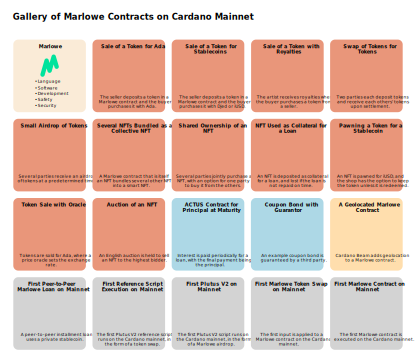

In [31]:
SVG(url='https://raw.githubusercontent.com/input-output-hk/awesome-marlowe/main/contracts/real-world-marlowe/gallery.svg')

[**more example contracts**](https://github.com/input-output-hk/marlowe-cardano/blob/main/marlowe/example-contracts.md)  

**we will use the following blockly code, similar to the marlowe code mentioned above**
![marlowe playground blockly code](../../image/marlowe_playground_swap_blockly.png)  

**You can export the script to ".json"**  
We stored this script and it's content looks like this.    

In [32]:
with open('../../data/contracts/swap_contract.json', 'r') as file:
    parsed = json.load(file)
    print(json.dumps(parsed, indent=2))

{
  "when": [
    {
      "then": {
        "when": [
          {
            "then": {
              "token": {
                "token_name": "",
                "currency_symbol": ""
              },
              "to": {
                "party": {
                  "role_token": "Buyer"
                }
              },
              "then": {
                "token": {
                  "token_name": "",
                  "currency_symbol": ""
                },
                "to": {
                  "party": {
                    "role_token": "Seller"
                  }
                },
                "then": "close",
                "pay": 0,
                "from_account": {
                  "role_token": "Buyer"
                }
              },
              "pay": 0,
              "from_account": {
                "role_token": "Seller"
              }
            },
            "case": {
              "party": {
                "role_token": "Buyer"
              

## Funding

### funds wallet

Create a "funds" wallet on the "Preview" network using  
a light wallet webapp and request 10.000 tADA (test ADA) to be sent to it.  
The purpose of this wallet is to distribute funds for the smart contract user wallets and  
test its functionality in a safe and controlled environment.  

#### Step 1: create or restore a funds wallet

Navigate to the light wallet webapp of your choice.  
Follow the steps to create or restore a wallet and make sure to select the "**Preview**" network.  
Once your wallet is created, make note of the wallet address for future use.  
  
If you opt to restore a wallet, you may utilize the previously generated 'funds' wallet:  

In [33]:
!cat funds.seed

primary they trust clip surge message indicate fiscal museum vacuum solar empty fog jaguar anger genre risk reason shine family luggage man night become


#### Step 2: request tADA

Visit the [**faucet page**](https://developers.cardano.org/docs/integrate-cardano/testnet-faucet/#testnets-faucet). Enter your wallet address and follow the instructions to request **10.000 tADA**.  

In [34]:
!cat payment.addr

addr_test1vrf3977xlrq29papwzxrmlu6ae0yjnvraatf9zx76m9f02s9g9rvw

<br>
<img src="../../image/preview_network_funds_wallet.png" width="50%"> 

### create wallet 1-2

We need 2 user wallets and sign keys to test the contract with.  
  * generate a mnemonic phrase for <b class="ttooltip">wallet1.seed<span class="tooltiptext">= personA = buyer = user1 = party1</span></b>
  * generate a payment verification key **wallet1.vkey**
  * generate a public address **wallet1.addr**  


  * **repeat for** <b class="ttooltip">wallet2.seed<span class="tooltiptext">= personB = seller = user2 = party2</span></b>  
  
Restore the wallets by entering the mnemonic recovery phrases generated below.  
<br>
<img src="../../image/eternl_restore_wallet_type.png" width="50%"> 

In [35]:
# generate 24 word 'mnemonic phrase' using cardano-wallet CLI command
cmd = [cardanoWALLET, "recovery-phrase", "generate", "--size", str(24)]
result = subprocess.run(cmd, capture_output=True, text=True)        # run the command
print("\033[1m'wallet 1' mnemonic phrase:\033[0m\n", result.stdout) # output the result
open('wallet1.seed', 'w').write(result.stdout)                      # save the result to a file 'wallet1.seed'

# create the payment SigningKey, secret to sign transactions with
!cat wallet1.seed | cardano-wallet key from-recovery-phrase Shelley | cardano-wallet key child 1852H/1815H/0H/0/0 > wallet1.prv
!cardano-cli key convert-cardano-address-key --shelley-payment-key --signing-key-file wallet1.prv --out-file wallet1.skey
!cardano-cli key verification-key --signing-key-file wallet1.skey --verification-key-file wallet1.vkey

# create the public wallet address
!cardano-cli address build --testnet-magic 2 --payment-verification-key-file wallet1.vkey > wallet1.addr
!rm wallet1.prv                                                     # remove root key, wallet1.skey is kept for token minting

# output the files content
print("\033[1m'wallet 1' payment verification key:\033[0m")
!cat wallet1.vkey
print("\n\033[1m'wallet 1' public PARTY1_ADDRESS:\033[0m")
!cat wallet1.addr

'wallet 1' mnemonic phrase:
 usual home hurt early conduct taste family finish silver appear gospel total couple negative run vessel zebra level wife network salt cinnamon sugar family

'wallet 1' payment verification key:
{
    "type": "PaymentExtendedVerificationKeyShelley_ed25519_bip32",
    "description": "",
    "cborHex": "58408691f3864474a804d2975506adc08193444a9bc0cba20596d25a14cd433592144532d79aee797cb799b40653a520186fce08cd7d36fd30c0facb571415c0cc9a"
}

'wallet 1' public PARTY1_ADDRESS:
addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n

In [36]:
# generate 24 word 'mnemonic phrase' using cardano-wallet CLI command
cmd = [cardanoWALLET, "recovery-phrase", "generate", "--size", str(24)]
result = subprocess.run(cmd, capture_output=True, text=True)        # run the command
print("\033[1m'wallet 2' mnemonic phrase:\033[0m\n", result.stdout) # output the result
open('wallet2.seed', 'w').write(result.stdout)                      # save the result to a file 'wallet2.seed'

# create the payment SigningKey, secret to sign transactions with
!cat wallet2.seed | cardano-wallet key from-recovery-phrase Shelley | cardano-wallet key child 1852H/1815H/0H/0/0 > wallet2.prv
!cardano-cli key convert-cardano-address-key --shelley-payment-key --signing-key-file wallet2.prv --out-file wallet2.skey
!cardano-cli key verification-key --signing-key-file wallet2.skey --verification-key-file wallet2.vkey

# create the public wallet address
!cardano-cli address build --testnet-magic 2 --payment-verification-key-file wallet2.vkey > wallet2.addr
!rm wallet2.prv                                                     # remove root key, wallet2.skey is kept for token minting

# output the files content
print("\033[1m'wallet 2' payment verification key:\033[0m")
!cat wallet2.vkey
print("\n\033[1m'wallet 2' public PARTY2_ADDRESS:\033[0m")
!cat wallet2.addr

'wallet 2' mnemonic phrase:
 vanish tortoise obtain celery injury universe figure relax dragon property boring wrap cake hood cook elbow idea mystery liquid strategy few tonight torch setup

'wallet 2' payment verification key:
{
    "type": "PaymentExtendedVerificationKeyShelley_ed25519_bip32",
    "description": "",
    "cborHex": "58408f110eed8fbde93b0bcf40063aa8665312f97d7980d27f9bc4a05cc468f21cd00053c8f500bf58b862da6fb7fb6bee4278654fb1b9ab64643ef67047b1ca263a"
}

'wallet 2' public PARTY2_ADDRESS:
addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er

In [37]:
# restrict file access and list all the wallet files generated
!date
!chmod 600 wallet?.*
!ls -al wallet?.*

Tue Apr  9 17:04:38 CEST 2024
-rw------- 1 ubuntu ubuntu  63 Apr  9 17:04 wallet1.addr
-rw------- 1 ubuntu ubuntu 156 Apr  9 17:04 wallet1.seed
-rw------- 1 ubuntu ubuntu 367 Apr  9 17:04 wallet1.skey
-rw------- 1 ubuntu ubuntu 244 Apr  9 17:04 wallet1.vkey
-rw------- 1 ubuntu ubuntu  63 Apr  9 17:04 wallet2.addr
-rw------- 1 ubuntu ubuntu 161 Apr  9 17:04 wallet2.seed
-rw------- 1 ubuntu ubuntu 367 Apr  9 17:04 wallet2.skey
-rw------- 1 ubuntu ubuntu 244 Apr  9 17:04 wallet2.vkey


In [38]:
# store the addresses in a variable
PARTY1_ADDRESS = open('wallet1.addr', 'r').read()
PARTY2_ADDRESS = open('wallet2.addr', 'r').read()

### transfer funds

Now that the funds wallet has received 10.000 tADA.  
Transfer in a **single transaction** a start capital of **500 tADA** to wallet PARTY 1-2.  
<br>
<div style="display:flex;">
    <img src="../../image/funded_wallets.png" style="margin-right: 10px;"/>
    <img src="../../image/eternl_funded_wallets.png"/>
</div>

<div style="font-family: monospace; background-color: #ffffff; padding: 10px; margin: 20px 0;">
    <p>Use the <code>marlowe-cli util fund-address</code> command to fund addresses from a source wallet.</p>
    <pre>
<span style="color: darkgreen; font-weight: bold;">(--mainnet | --testnet-magic INTEGER)</span>          Specify the network environment (mainnet or testnet)
<span style="color: gray;">[--socket-path SOCKET_FILE]</span>                    Set the socket path for inter-process communication with cardano-node
<span style="color: darkgreen; font-weight: bold;">(--lovelace LOVELACE | --send-all)</span>             Set a lovelace amount to transfer, or allocate all existing funds
<span style="color: darkgreen; font-weight: bold;">--out-file FILE</span>                                Path to save transaction body, or use /dev/null to discard
<span style="color: gray;">[--submit SECONDS]</span>                             Submit transaction, await confirmation with timeout in seconds
<span style="color: darkgreen; font-weight: bold;">--source-wallet-credentials ADDRESS:SIGNING_FILE</span>  Credentials for the source wallet sending the funds
<span style="color: darkgreen; font-weight: bold;">ADDRESS</span>                                        Specify recipient addresses for fund distribution, multiple allowed
<span style="color: gray;">[--help]</span>                                       Display help information</pre>
</div>


In [39]:
# setting some variables
MAGIC                 = '2'
SOCKET                = '/tmp/node.socket'
ADA                   = 1000000
FUNDS_ADDRESS         = open('payment.addr', 'r').read()
FUNDS_SKEYFILE        = 'payment.skey'
PARTY1_ADDRESS        = open('wallet1.addr', 'r').read()
PARTY2_ADDRESS        = open('wallet2.addr', 'r').read()

# fund two address wallets PARTY 1-2
cmd = [marloweCLI, "util", "fund-address", 
    "--testnet-magic", MAGIC,
    "--socket-path", SOCKET,
    "--lovelace", str(500*ADA),              # 500 ADA amount
    "--out-file", "/dev/null",
    "--source-wallet-credentials", FUNDS_ADDRESS+":"+FUNDS_SKEYFILE,  # this faucet address willing to provide funds
    "--submit", str(600),                   # submit the transaction, and wait for confirmation (max 10min)
    PARTY1_ADDRESS, PARTY2_ADDRESS]         # list all addresses to send test funds to
result = subprocess.run(cmd, capture_output=True, text=True)
print("\033[1msuccessful UTxO transaction:\033[0m" if not result.stderr.strip() else result.stderr)
print(result.stdout)
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

successful UTxO transaction:
TxId "14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333"

executed shell command:
marlowe-cli util fund-address --testnet-magic 2 --socket-path /tmp/node.socket --lovelace 500000000 --out-file /dev/null --source-wallet-credentials addr_test1vrf3977xlrq29papwzxrmlu6ae0yjnvraatf9zx76m9f02s9g9rvw:payment.skey --submit 600 addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er


In [40]:
# check wallet1 and wallet2 using the helper function
pd.concat([query_df(PARTY1_ADDRESS), query_df(PARTY2_ADDRESS)]).reset_index(drop=True)

,address,TxHash,TxIx,lovelace,datumhash,TokenPolicyId,TokenNameHex,TokenAmount
0,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333,1,500000000,NaN,NaN,NaN,0
1,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333,2,500000000,NaN,NaN,NaN,0


## Parameters

They dictate the terms of the contract and follow predefined conditions.  
Each time you establish a contract script, the script need values hard-coded before deployment.  
For example,  
  * each PARTY need to define the amount of TOKEN/ADA to exchange in a swap contract  
  * the deadline for each PARTY to send their amount of ADA in time, else it is cancelled  
  * the PolicyID/address that gives you the right to participate in the contract  

Floating-point arithmetic will lead to rounding errors, which are problematic in precise financial contracts.  
For example:  

In [41]:
# example of an inaccuracy and rounding error
print(f"a = 0.1\nb = 0.2\nc = a + b\n  = {0.1 + 0.2}")

a = 0.1
b = 0.2
c = a + b
  = 0.30000000000000004


Instead of 0.3,  
you get a significant error in more complex calculations with large numbers like financial transactions or **contracts**.  
To mitigate issues of precision:
  * The integer representation for a timestamp **2023-02-28 15:24:40** in <b class="ttooltip">POSIX<span class="tooltiptext">The number of seconds counted from the beginning of time 01-01-1970</span></b> is **1677594280000**
  * The integer representation for a currency **3** ADA is **3000000** <b class="ttooltip">lovelace<span class="tooltiptext">ADA can be divided into 1,000,000 lovelaces (0.000001 ADA)</span></b>
  * When running marlowe-cli commands, use **str(value)** to convert into strings  

In [42]:
MAGIC                 = '2'             # preview (NetworkMagic: 2)
SOCKET                = '/tmp/node.socket'
ADA                   = 1000000         # 1 ADA = 1000000 lovelace (6 decimal places)
MINIMUM_ADA           = 3*ADA           # The minimum lovelace to be included with native token output

cmd                   = [marloweCLI, "util", "slotting", "--testnet-magic", MAGIC, "--socket-path", SOCKET]
result                = subprocess.run(cmd, capture_output=True, text=True)
SLOT_LENGTH           = json.loads(result.stdout)["scSlotLength"]   # 1000 (ms), duration of one slot
SLOT_OFFSET           = json.loads(result.stdout)["scSlotZeroTime"] # 1666656000000 (ms), start time of first slot
cmd                   = [cardanoCLI, "query", "tip", "--testnet-magic", MAGIC]
result                = subprocess.run(cmd, capture_output=True, text=True)
CURRENT_SLOT          = json.loads(result.stdout)["slot"]  # 8938685 (slot), current latest slot number (= TIP) 
CURRENT_TIME          = round(time.time())*SLOT_LENGTH     # 1675594685000 (ms), CURRENT_SLOT*SLOT_LENGTH+SLOT_OFFSET
HOUR_SLOT             = 60*60                              # 3600 (slot)
HOUR_TIME             = 60*60*SLOT_LENGTH                  # 3600000 (ms), One hour, in POSIX milliseconds
DAY_SLOT              = 24*60*60                           # 86400 (slot)
DAY_TIME              = 24*60*60*SLOT_LENGTH               # 86400000 (ms)
MINT_DEADLINE_SLOT    = CURRENT_SLOT+int(2*HOUR_SLOT)      # The token minting deadline (+2h)
MINT_DEADLINE_TIME    = CURRENT_TIME+2*HOUR_TIME           # The token minting deadline (+2h)
PARTY1_DEADLINE_SLOT  = CURRENT_SLOT+int(10*HOUR_SLOT)     # The payment deadline (+10h)
PARTY1_DEADLINE_TIME  = (CURRENT_TIME+10*HOUR_TIME)        # The payment deadline (+10h)
PARTY2_DEADLINE_SLOT  = CURRENT_SLOT+int(24*HOUR_SLOT)     # The payment deadline (+24h)
PARTY2_DEADLINE_TIME  = (CURRENT_TIME+24*HOUR_TIME)        # The payment deadline (+24h)
METADATA_FILE         = 'NFTMintData.json'                 # the NFT metadata *.json file

PARTY1_TOKEN_NAME     = ""              # "" is 'ADA', 'token_name' used to swap (ex: CHOC)
PARTY2_TOKEN_NAME     = ""              # "" is 'ADA', 'token_name' used to swap (ex: BERRY)
PARTY1_TOKEN_POLICYID = ""              # "" is 'Cardano', the 'currency_symbol' policy ID (ex: "0b8ffef9a24d8d...7e43")
PARTY2_TOKEN_POLICYID = ""              # "" is 'Cardano', the 'currency_symbol' policy ID (ex: "0b8ffef9a24d8d...7e43")
PARTY1_ROLE_NAME      = 'Party1'        # this is 'Buyer', 'wallet 1'
PARTY2_ROLE_NAME      = 'Party2'        # this is 'Seller', 'wallet 2'
PARTY1_ROLE_POLICYID  = ""              # minted Policy ID to be created later (ex: "0b8ffef9a24d8d...7e43")
PARTY2_ROLE_POLICYID  = ""              # minted Policy ID to be created later (ex: "0b8ffef9a24d8d...7e43")
PARTY1_AMOUNT         = 200*ADA         # 200000000, means we will hard-code this swap amount in the script
PARTY2_AMOUNT         = 100*ADA         # 100000000, means we will hard-code this swap amount in the script
PARTY1_ADDRESS        = open('wallet1.addr', 'r').read() # string value of the Buyer  address (wallet 1)
PARTY2_ADDRESS        = open('wallet2.addr', 'r').read() # string value of the Seller address (wallet 2)
PARTY1_SKEYFILE       = 'wallet1.skey'
PARTY2_SKEYFILE       = 'wallet2.skey'
PARTY1_VKEYFILE       = 'wallet1.vkey'
PARTY2_VKEYFILE       = 'wallet2.vkey'

In [43]:
# helper function to make time value readable
def convert_timestamp(timestamp):
    return datetime.datetime.fromtimestamp(timestamp/1000)

# demonstrate the values
print(f"\033[1mMINIMUM_ADA:\033[0m \t\t{MINIMUM_ADA} (lovelace) \t\t= \033[1m{int(MINIMUM_ADA/ADA)} ADA\033[0m")
print(f"\033[1mPARTY1_AMOUNT:\033[0m \t\t{PARTY1_AMOUNT} (lovelace) \t\t= \033[1m{int(PARTY1_AMOUNT/ADA)} ADA (to be swapped)\033[0m")
print(f"\033[1mPARTY2_AMOUNT:\033[0m \t\t{PARTY2_AMOUNT} (lovelace) \t\t= \033[1m{int(PARTY2_AMOUNT/ADA)} ADA (to be swapped)\033[0m")
print(f"\033[1mCURRENT_SLOT:\033[0m \t\t{CURRENT_SLOT} (slot) \t\t= \033[1mcurrent slot number (now, TIP)\033[0m")
print(f"\033[1mCURRENT_TIME:\033[0m \t\t{CURRENT_TIME} (ms) \t\t= \033[1m{convert_timestamp(CURRENT_TIME)} (now, TIP)\033[0m")
print(f"\033[1mMINT_DEADLINE_SLOT:\033[0m \t{MINT_DEADLINE_SLOT} (slot) \t\t= \033[1mfuture slot number  (2 hours from now)\033[0m")
print(f"\033[1mMINT_DEADLINE_TIME:\033[0m \t{MINT_DEADLINE_TIME} (ms) \t\t= \033[1m{convert_timestamp(MINT_DEADLINE_TIME)} (2 hours from now)\033[0m")
print(f"\033[1mPARTY1_DEADLINE_SLOT:\033[0m \t{PARTY1_DEADLINE_SLOT} (slot) \t\t= \033[1mfuture slot number  (10 hours from now)\033[0m")
print(f"\033[1mPARTY1_DEADLINE_TIME:\033[0m \t{PARTY1_DEADLINE_TIME} (ms) \t\t= \033[1m{convert_timestamp(PARTY1_DEADLINE_TIME)} (10 hours from now)\033[0m")
print(f"\033[1mPARTY2_DEADLINE_SLOT:\033[0m \t{PARTY2_DEADLINE_SLOT} (slot) \t\t= \033[1mfuture slot number  (24 hours from now)\033[0m")
print(f"\033[1mPARTY2_DEADLINE_TIME:\033[0m \t{PARTY2_DEADLINE_TIME} (ms) \t\t= \033[1m{convert_timestamp(PARTY2_DEADLINE_TIME)} (24 hours from now)\033[0m")

MINIMUM_ADA: 		3000000 (lovelace) 		= 3 ADA
PARTY1_AMOUNT: 		200000000 (lovelace) 		= 200 ADA (to be swapped)
PARTY2_AMOUNT: 		100000000 (lovelace) 		= 100 ADA (to be swapped)
CURRENT_SLOT: 		46019101 (slot) 		= current slot number (now, TIP)
CURRENT_TIME: 		1712675112000 (ms) 		= 2024-04-09 17:05:12 (now, TIP)
MINT_DEADLINE_SLOT: 	46026301 (slot) 		= future slot number  (2 hours from now)
MINT_DEADLINE_TIME: 	1712682312000 (ms) 		= 2024-04-09 19:05:12 (2 hours from now)
PARTY1_DEADLINE_SLOT: 	46055101 (slot) 		= future slot number  (10 hours from now)
PARTY1_DEADLINE_TIME: 	1712711112000 (ms) 		= 2024-04-10 03:05:12 (10 hours from now)
PARTY2_DEADLINE_SLOT: 	46105501 (slot) 		= future slot number  (24 hours from now)
PARTY2_DEADLINE_TIME: 	1712761512000 (ms) 		= 2024-04-10 17:05:12 (24 hours from now)


### time

An **epoch** is a time period (5 days) divided into smaller time "_slots_" during which the network operates.  
Each <b class="ttooltip">slot<span class="tooltiptext">a unit of time within an epoch (1 second).</span></b> is assigned to a "_slot leader_" to verify the transactions and add a new "block" to the blockchain.  
A <b class="ttooltip">block<span class="tooltiptext">The average interval of 20 seconds between block is given by the "density" parameter, which is "0.05", meaning 5 blocks in average for every 100 seconds.</span></b> is a group of verified transactions that have been added to the blockchain in a specific slot.  

||<b><span style="color:#5A9BFD">MAINNET</span></b>|<b><span style="color:#E6AA00">PREVIEW</span></b>|
|-|-|-|
|slots per second|**1**|**1**|
|slot leader per block|**1**|**1**|
|slots per block|**20**|**20**|
|blocks per epoch|**21600**|**4320**|
|slots per epoch|**432000**|**86400**|
|days per epoch|**5**|**1**|

![visualise cardano time frames](../../image/visualise_cardano_timeframes.png)

## Tokens

Each wallet requires a token to establish ownership, granting the right to interact with the contract.  
This process relies on the unique <b class="ttooltip">policyID<span class="tooltiptext">A policyID is a unique identifier produced from the policy script. It sets the minting and burning rules for native tokens on Cardano, ensuring each policy's uniqueness. The Mainnet uses the CIP26 off-chain metadata registry for this purpose. PolicyIDs are permanently associated with their tokens, securing against unauthorized alterations and safeguarding asset integrity.</span></b> of the tokens, which is hard-coded into the contract for security and uniqueness.  

"**Party1**" initiates the minting of two **tokens**, one for themselves and another for "Party2" and responsible for covering the transaction **fee**.  

![mint tokens](../../image/mint_tokens.png)  

**marlowe-cli** offers a streamlined approach for minting tokens with **metadata**  
It's crucial to ensure the string values for each attribute is **less than 65 characters long**.  

#### image handling

For simplicity we chose to store off-chain and use images from this GitHub repository.  
To comply with the character limit, we consider using shortened URLs for linking image in token metadata.  
In the field use open, robust, resilient and decentralized storage like [IPFS](https://docs.ipfs.tech/) and [Iagon](https://docs.iagon.com/docs/documentation/introduction)  
Images of any size are acceptable; they're auto-adjusted to 1024x1024 for optimal display in the Eternl wallet.  

In [44]:
# Shortening image URLs for NFT metadata
cat = 'https://raw.githubusercontent.com/littlefish-foundation/cardano-contracts-cookbook/master/image/cat_pawn_squared_white.png'
cat_tinyURL = requests.get(f'https://tinyurl.com/api-create.php?url={cat}')
print(f"short link to image (cat) Party1: {cat_tinyURL.text.replace('http:', 'https:')}")

owl = 'https://raw.githubusercontent.com/littlefish-foundation/cardano-contracts-cookbook/master/image/owl_pawn_squared_white.png'
owl_tinyURL = requests.get(f'https://tinyurl.com/api-create.php?url={owl}')
print(f"short link to image (owl) Party2: {owl_tinyURL.text.replace('http:', 'https:')}")

short link to image (cat) Party1: https://tinyurl.com/2xlch3de
short link to image (owl) Party2: https://tinyurl.com/28lqb6go


### token metadata
  
Storing this into **NFTMintData.json**, this structure will create two different NFTs.  

<pre>
{
  <span style="color: darkred;">"Party1"</span>: {
    <span style="color: darkred;">"name"</span>: <span style="color: darkgreen;">"Lady Whisker (Party1)"</span>,
    <span style="color: darkred;">"id"</span>: <span style="color: darkgreen;">"0001"</span>,
    <span style="color: darkred;">"description"</span>: <span style="color: darkgreen;">"... never more than 64 characters long string allowed ..."</span>,
    <span style="color: darkred;">"image"</span>: <span style="color: darkgreen;">"https://tinyurl.com/2xlch3de"</span>,
    <span style="color: darkred;">"mediaType"</span>: <span style="color: darkgreen;">"image/png"</span>,
    <span style="color: darkred;">"attributes"</span>: [
      {<span style="color: darkred;">"trait_type"</span>: <span style="color: darkgreen;">"Category"</span>, <span style="color: darkred;">"value"</span>: <span style="color: darkgreen;">"Chess Piece"</span>},
      {<span style="color: darkred;">"trait_type"</span>: <span style="color: darkgreen;">"Rank"</span>, <span style="color: darkred;">"value"</span>: <span style="color: darkgreen;">"Pawn"</span>},
      {<span style="color: darkred;">"trait_type"</span>: <span style="color: darkgreen;">"Theme"</span>, <span style="color: darkred;">"value"</span>: <span style="color: darkgreen;">"Cat"</span>},
      {<span style="color: darkred;">"trait_type"</span>: <span style="color: darkgreen;">"Color Palette"</span>, <span style="color: darkred;">"value"</span>: <span style="color: darkgreen;">"Monochrome"</span>},
      {<span style="color: darkred;">"trait_type"</span>: <span style="color: darkgreen;">"Expression"</span>, <span style="color: darkred;">"value"</span>: <span style="color: darkgreen;">"Serene"</span>}],
    <span style="color: darkred;">"year"</span>: <span style="color: darkblue;">2024</span>,
    <span style="color: darkred;">"external_url"</span>: <span style="color: darkgreen;">"https://example.com"</span>
  },
  <span style="color: darkred;">"Party2"</span>: {
    <span style="color: darkred;">"name"</span>: <span style="color: darkgreen;">"Lord Hoot (Party2)"</span>,
    <span style="color: darkred;">"id"</span>: <span style="color: darkgreen;">"0002"</span>,
    <span style="color: darkred;">"description"</span>: <span style="color: darkgreen;">"artwork on the subject of experimenting with NFT deployment"</span>,
    <span style="color: darkred;">"image"</span>: <span style="color: darkgreen;">"https://tinyurl.com/28lqb6go"</span>,
    <span style="color: darkred;">"mediaType"</span>: <span style="color: darkgreen;">"image/png"</span>,
    <span style="color: darkred;">"attributes"</span>: [
      {<span style="color: darkred;">"trait_type"</span>: <span style="color: darkgreen;">"Category"</span>, <span style="color: darkred;">"value"</span>: <span style="color: darkgreen;">"Chess Piece"</span>},
      {<span style="color: darkred;">"trait_type"</span>: <span style="color: darkgreen;">"Rank"</span>, <span style="color: darkred;">"value"</span>: <span style="color: darkgreen;">"Pawn"</span>},
      {<span style="color: darkred;">"trait_type"</span>: <span style="color: darkgreen;">"Theme"</span>, <span style="color: darkred;">"value"</span>: <span style="color: darkgreen;">"Owl"</span>},
      {<span style="color: darkred;">"trait_type"</span>: <span style="color: darkgreen;">"Color Palette"</span>, <span style="color: darkred;">"value"</span>: <span style="color: darkgreen;">"Monochrome"</span>},
      {<span style="color: darkred;">"trait_type"</span>: <span style="color: darkgreen;">"Expression"</span>, <span style="color: darkred;">"value"</span>: <span style="color: darkgreen;">"Wise"</span>}],
    <span style="color: darkred;">"year"</span>: <span style="color: darkblue;">2024</span>,
    <span style="color: darkred;">"external_url"</span>: <span style="color: darkgreen;">"https://example.com"</span>
  }
}
</pre>

#### token metadata considerations

Place the **"name"** attribute next on top of the list, this can be the assetName in ascii form or more descriptive.  
Ensure all links, especially image URIs, to use **"https"** instead of http.  
Recommended to use string datatype values for **"id"**, this preserves leading zeros.    
It is up to you design for additional metadata attributes and values.  
**[CIP-25](https://cips.cardano.org/cips/cip25)** has metadata in the transaction metadata field, which is stored offchain and  
not on the UTxO, thus cannot be read by smart contracts.  
**[CIP-68](https://cips.cardano.org/cips/cip68)** NFT data is located in the **datum**, it is explicitly readable and changable  
by smart contracts designed to update this data.  
Be aware that marlowe-cli does not support CIP-68.  

### token minting

<div style="font-family: monospace; background-color: #ffffff; padding: 10px; margin: 20px 0;">
    <p>Use the <code>marlowe-cli util mint</code> command to create native tokens.</p>
    <pre>
<span style="color: darkgreen; font-weight: bold;">(--mainnet | --testnet-magic INTEGER)</span>          Specify the network environment (mainnet or testnet)
<span style="color: gray;">[--socket-path SOCKET_FILE]</span>                    Set the socket path for inter-process communication with cardano-node
<span style="color: darkgreen; font-weight: bold;">--issuer ADDRESS:SIGNING_FILE</span>                  Specify the issuer's address and signing key file
<span style="color: gray;">[--token-provider ADDRESS:SIGNING_FILE]</span>        Define additional token owner's address and signing key
<span style="color: gray;">[--metadata-file JSON_FILE]</span>                    Specify JSON file for CIP-25 token metadata
<span style="color: gray;">[--count INTEGER]</span>                              Set the quantity of tokens to mint
<span style="color: gray;">[--expires SLOT_NO]</span>                            Set a mint/burn deadline; endless if not used, offering adjustments
<span style="color: darkgreen; font-weight: bold;">--out-file FILE</span>                                Path to save transaction body, or use /dev/null to discard
<span style="color: gray;">[--submit SECONDS]</span>                             Submit transaction, await confirmation with timeout in seconds
<span style="color: darkgreen; font-weight: bold;">TOKEN_NAME:ADDRESS</span>                             Define which role token to send to which address upon minting
<span style="color: gray;">[--help]</span>                                       Display help information</pre>
</div>

In [45]:
cmd = [marloweCLI, "util", "mint",                  # create tokens
    "--testnet-magic", MAGIC,
    "--socket-path", SOCKET,
    "--issuer", PARTY1_ADDRESS+":"+PARTY1_SKEYFILE,
    "--metadata-file", METADATA_FILE,               # opens NFTMintData.json and add "721": {"<policy_id>": {...}} 
    "--count", str(1),                              # we mint only 1 of each
    "--expires", str(MINT_DEADLINE_SLOT),           # we allow ~2 hour window to mint more
    "--out-file", "/dev/null",
    "--submit", str(600),                           # submit the transaction, and wait for confirmation (max 10min)
    PARTY1_ROLE_NAME+":"+PARTY1_ADDRESS,            # where to send the tokens to
    PARTY2_ROLE_NAME+":"+PARTY2_ADDRESS]            # Party1, Party2 -- do not use quotes like "PARTY1_ROLE_NAME"
result = subprocess.run(cmd, capture_output=True, text=True)
print("\033[1msuccessful UTxO transaction:\033[0m" + result.stderr if len(result.stderr.strip()) < 150 else result.stderr)
print(f"\033[1mgenerated policyID: \033[0m{result.stdout.strip()}\t\033[1mexpires:\033[0m {convert_timestamp(MINT_DEADLINE_TIME)}\n")
print("\033[1mshell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

successful UTxO transaction:
Fee: Lovelace 218741
Size: 1247 / 16384 = 7%
Execution units:
  Memory: 0 / 14000000 = 0%
  Steps: 0 / 10000000000 = 0%

generated policyID: 45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925	expires: 2024-04-09 19:05:12

shell command:
marlowe-cli util mint --testnet-magic 2 --socket-path /tmp/node.socket --issuer addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n:wallet1.skey --metadata-file NFTMintData.json --count 1 --expires 46026301 --out-file /dev/null --submit 600 Party1:addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n Party2:addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er


In [46]:
# view the minted tokens on an explorer, searching for the policyID
print(f"https://preview.cexplorer.io/{result.stdout}")

https://preview.cexplorer.io/45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925



Only the essential identifiers <b class="ttooltip">"policyID"<span class="tooltiptext">A unique identifier for the policy under which the NFT is minted, ensuring the asset's uniqueness and compliance with the blockchain's rules.</span></b> and <b class="ttooltip">"assetName"<span class="tooltiptext">The name of the asset in hexadecimal form. It's a secondary identifier that works alongside the policyID to uniquely identify an NFT.</span></b> are important for the localisation of the token in a smart contract.  
You could use an **ADA Handle** in your smart contract if you [mint on the preview network](https://preview.mint.handle.me/mint), it works basically the same.  

![policyid_and_assetname](../../image/policyid_assetname.png)  

In [47]:
# check wallet1 and wallet2 latest transaction data
df = pd.concat([query_df(PARTY1_ADDRESS), query_df(PARTY2_ADDRESS)])
# Convert 'address' column to a Categorical type with defined ordering
df['address'] = pd.Categorical(df['address'], categories=[PARTY1_ADDRESS, PARTY2_ADDRESS], ordered=True)
# sort by prioritizing addresses, then by TokenAmount ascending, and resets index numbering
df = df.sort_values(by=['address', 'TokenAmount']).reset_index(drop=True)

# store the PolicyID
PARTY1_ROLE_POLICYID = df[(df['TokenNameAscii'] == PARTY1_ROLE_NAME)].iloc[0]['TokenPolicyId']
PARTY2_ROLE_POLICYID = df[(df['TokenNameAscii'] == PARTY2_ROLE_NAME)].iloc[0]['TokenPolicyId']

# Print the Policy IDs and Asset Names using the simplified approach
print(f'Policy ID \t {PARTY1_ROLE_POLICYID}')
print(f"Asset Name \t {PARTY1_ROLE_NAME}\n")
print(f'Policy ID \t {PARTY2_ROLE_POLICYID}')
print(f"Asset Name \t {PARTY2_ROLE_NAME}")

Policy ID 	 45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925
Asset Name 	 Party1

Policy ID 	 45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925
Asset Name 	 Party2


<div style="font-family: monospace; background-color: #f0f0f0; border-left: 5px solid #33b5e5; padding: 10px; margin: 20px 0;">

<strong>Hexadecimal to ASCII Conversion:</strong><br>

The hex value <code style="background-color: #ebfbee; color: #34a853; padding: 2px 4px; border-radius: 4px;">506172747931</code>
→
converts to ASCII as <code style="background-color: #fff3cd; color: #856404; padding: 2px 4px; border-radius: 4px;">Party1</code>.<br>
The hex value <code style="background-color: #ebfbee; color: #34a853; padding: 2px 4px; border-radius: 4px;">506172747932</code>
→
converts to ASCII as <code style="background-color: #fff3cd; color: #856404; padding: 2px 4px; border-radius: 4px;">Party2</code>.

</div>

Each transaction produces a unique <b class="ttooltip">TxHash<span class="tooltiptext">The unique identifier for a transaction, generated by hashing its content. It's used to track and reference transactions within the blockchain.</span></b>, which identifies the transaction as a whole.  
A <b class="ttooltip">TxIx<span class="tooltiptext">The index of a specific output in a transaction, starting from 0. It identifies each output within a transaction, allowing organizing multiple outputs.</span></b> refers to individual outputs within that transaction.  
Together, TxHash and TxIx facilitate precise tracking and organization of transaction outputs on the Cardano blockchain.

Example TxHash: **751df56d4f7c0281ae9d6f3dcc99f16da6c388100b7f03a40d32001a90e3448d**  
For a transaction with 3 outputs, the TxIx values would be **0, 1, and 2**.


In [48]:
# store the OUTPUTS (TxHash + '#' + TxIx)
TX1_PARTY1_ADA   = df.loc[0]['TxHash'] + '#' + str(df.loc[0]['TxIx'])
TX1_PARTY1_TOKEN = df.loc[1]['TxHash'] + '#' + str(df.loc[1]['TxIx'])
TX1_PARTY2_ADA   = df.loc[2]['TxHash'] + '#' + str(df.loc[2]['TxIx'])
TX1_PARTY2_TOKEN = df.loc[3]['TxHash'] + '#' + str(df.loc[3]['TxIx'])

print(f'  VARIABLE NAME\t\t: \t\t\t\tTxHash\t\t\t\t\tTxIx')
print(f'----------------------------------------------------------------------------------------------------')
print(f'TX1_PARTY1_ADA\t\t: {TX1_PARTY1_ADA[:-2]}   +   {TX1_PARTY1_ADA[-2:]}')
print(f'TX1_PARTY1_TOKEN\t: {TX1_PARTY1_TOKEN[:-2]}   +   {TX1_PARTY1_TOKEN[-2:]}')
print(f'TX1_PARTY2_ADA\t\t: {TX1_PARTY2_ADA[:-2]}   +   {TX1_PARTY2_ADA[-2:]}')
print(f'TX1_PARTY2_TOKEN\t: {TX1_PARTY2_TOKEN[:-2]}   +   {TX1_PARTY2_TOKEN[-2:]}')

  VARIABLE NAME		: 				TxHash					TxIx
----------------------------------------------------------------------------------------------------
TX1_PARTY1_ADA		: df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54   +   #0
TX1_PARTY1_TOKEN	: df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54   +   #1
TX1_PARTY2_ADA		: 14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333   +   #2
TX1_PARTY2_TOKEN	: df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54   +   #2


In [49]:
df

,address,TxHash,TxIx,lovelace,TokenPolicyId,TokenNameHex,TokenNameAscii,TokenAmount,datumhash
0,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54,0,497712459,NaN,NaN,None,0,NaN
1,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54,1,1034400,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747931,Party1,1,NaN
2,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333,2,500000000,NaN,NaN,None,0,NaN
3,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54,2,1034400,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747932,Party2,1,NaN


## Transactions

### modify contract parameters

We embed specific, real-world values directly into the JSON script,  
programmatically substituting placeholders with concrete data like PARTY1_TOKEN_NAME,  
PARTY1_TOKEN_POLICYID, and the corresponding amounts and deadlines.  
This precise customization process ensures our smart contract is not only functional but robust and adaptable to user needs.  

In [50]:
contract_data = {
  "when": [
    {
      "then": {
        "when": [
          {
            "then": {
              "token": {
                "token_name": PARTY1_TOKEN_NAME,
                "currency_symbol": PARTY1_TOKEN_POLICYID
              },
              "to": {
                "party": {
                  "role_token": PARTY2_ROLE_NAME
                }
              },
              "then": {
                "token": {
                  "token_name": PARTY2_TOKEN_NAME,
                  "currency_symbol": PARTY2_TOKEN_POLICYID
                },
                "to": {
                  "party": {
                    "role_token": PARTY1_ROLE_NAME
                  }
                },
                "then": "close",
                "pay": PARTY2_AMOUNT,
                "from_account": {
                  "role_token": PARTY2_ROLE_NAME
                }
              },
              "pay": PARTY1_AMOUNT,
              "from_account": {
                "role_token": PARTY1_ROLE_NAME
              }
            },
            "case": {
              "party": {
                "role_token": PARTY2_ROLE_NAME
              },
              "of_token": {
                "token_name": PARTY2_TOKEN_NAME,
                "currency_symbol": PARTY2_TOKEN_POLICYID
              },
              "into_account": {
                "role_token": PARTY2_ROLE_NAME
              },
              "deposits": PARTY2_AMOUNT
            }
          }
        ],
        "timeout_continuation": "close",
        "timeout": PARTY2_DEADLINE_TIME
      },
      "case": {
        "party": {
          "role_token": PARTY1_ROLE_NAME
        },
        "of_token": {
          "token_name": PARTY1_TOKEN_NAME,
          "currency_symbol": PARTY1_TOKEN_POLICYID
        },
        "into_account": {
          "role_token": PARTY1_ROLE_NAME
        },
        "deposits": PARTY1_AMOUNT
      }
    }
  ],
  "timeout_continuation": "close",
  "timeout": PARTY1_DEADLINE_TIME
}

# Write the dictionary to a file in JSON format
with open('tx-1.contract', 'w') as file:
    json.dump(contract_data, file, indent=2)

In [51]:
!cat tx-1.contract

{
  "when": [
    {
      "then": {
        "when": [
          {
            "then": {
              "token": {
                "token_name": "",
                "currency_symbol": ""
              },
              "to": {
                "party": {
                  "role_token": "Party2"
                }
              },
              "then": {
                "token": {
                  "token_name": "",
                  "currency_symbol": ""
                },
                "to": {
                  "party": {
                    "role_token": "Party1"
                  }
                },
                "then": "close",
                "pay": 100000000,
                "from_account": {
                  "role_token": "Party2"
                }
              },
              "pay": 200000000,
              "from_account": {
                "role_token": "Party1"
              }
            },
            "case": {
              "party": {
                "role_token": "Par

The **minTime=1** setting signals the contract can start **anytime** after January 1, 1970.  
It allows the contract to adapt with evolving accounts and choices.  
A minimum balance of **3 ADA** in accounts serves as a security measure.  

In [52]:
state_data = {
    "accounts": [
        [[{"role_token": PARTY1_ROLE_NAME}, {"currency_symbol": PARTY1_TOKEN_POLICYID, "token_name": PARTY1_TOKEN_NAME}], MINIMUM_ADA]
    ],
    "choices": [],
    "boundValues": [],
    "minTime": 1
}

# Write the dictionary to a file in JSON format
with open('tx-1.state', 'w') as file:
    json.dump(state_data, file, indent=2)

In [53]:
!cat tx-1.state

{
  "accounts": [
    [
      [
        {
          "role_token": "Party1"
        },
        {
          "currency_symbol": "",
          "token_name": ""
        }
      ],
      3000000
    ]
  ],
  "choices": [],
  "boundValues": [],
  "minTime": 1
}

### transaction #1 start contract (3 ADA)

#### initialize

Generate the *.marlowe file with json files *.contract, *.state, plutus data and network info.

<div style="font-family: monospace; background-color: #ffffff; padding: 10px; margin: 20px 0;">
    <p>Use the <code>marlowe-cli run initialize</code> command to initialize the first transaction of a Marlowe contract.</p>
    <pre>
<span style="color: darkgreen; font-weight: bold;">(--mainnet | --testnet-magic INTEGER)</span>          Specify the network environment (mainnet or testnet)
<span style="color: gray;">[--socket-path SOCKET_FILE]</span>                    Set the socket path for inter-process communication with cardano-node
<span style="color: gray;">[--stake-address ADDRESS]</span>                      Specify a stake address, if applicable
<span style="color: gray;">[--roles-currency CURRENCY_SYMBOL]</span>             Define the currency symbol for roles, if applicable
<span style="color: darkgreen; font-weight: bold;">--contract-file CONTRACT_FILE</span>                  Path to the JSON input file for the contract
<span style="color: darkgreen; font-weight: bold;">--state-file STATE_FILE</span>                        Path to the JSON input file for the contract's state
<span style="color: gray;">[--at-address ADDRESS | --permanently STAKING_ADDRESS | --permanently-without-staking]</span> <br>                                               Optional script publication method at a specific address,
                                               permanently with staking (earn rewards) or permanently without staking
<span style="color: darkgreen; font-weight: bold;">--out-file OUTPUT_FILE</span>                         Path to save transaction body, or use /dev/null to discard
<span style="color: gray;">[--merkleize]</span>                                  Option to deeply merkleize the contract
<span style="color: gray;">[--print-stats]</span>                                Print transaction statistics
<span style="color: gray;">[--help]</span>                                       Display help information</pre>
</div>

In [54]:
cmd = [marloweCLI, "run", "initialize",          # Initialize the first transaction of a Marlowe contract
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--roles-currency", PARTY1_ROLE_POLICYID,
       "--permanently-without-staking",          # enable optional reference script(without staking), 10x smaller tx size
       "--contract-file", "tx-1.contract",       # input 1/2 contract code
       "--state-file", "tx-1.state",             # input 2/2 state
       "--out-file", "tx-1.marlowe",             # generated Marlowe contract
       "--print-stats"]
result = subprocess.run(cmd, capture_output=True, text=True)
print(result.stdout)
print(result.stderr.replace('\n\n', '\n')[1:])
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))


Searching for reference script at address: addr_test1vrdw72k9ejttl6ng4gzl0t0vq68z2mzx4wdnr6v3554585q5dlfp8
Expected reference script hash: "6027a8010c555a4dd6b08882b899f4b3167c6e4524047132202dd984"
Searching for reference script at address: addr_test1vznzngme83923qgm66a2lnl7ln03t2qx4r4ay4s4w80ghpgf9q5yf
Expected reference script hash: "fdade3b86107bc715037b468574dd8d3f884a0da8c9956086b9a1a51"
Searching for reference script at address: addr_test1vqc4sgdyl29e54qplz268sg96xxj82jfnl70xtc52narplgppcf09
Expected reference script hash: "36a5c7e49a6b11c7fb65fb61db69ed5ceaa35326af9d952fd30185c0"
Validator size: 10779
Base-validator cost: ExBudget {exBudgetCPU = ExCPU 16951100, exBudgetMemory = ExMemory 73800}

executed shell command:
marlowe-cli run initialize --testnet-magic 2 --socket-path /tmp/node.socket --roles-currency 45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925 --permanently-without-staking --contract-file tx-1.contract --state-file tx-1.state --out-file tx-1.marlowe --prin

#### reference scripts

[CIP-33](https://cips.cardano.org/cips/cip33/) introduces frequently-used scripts minimization by embedding them once.  
`marlowe-cli run initialize` with `--permanently-without-staking` efficiently links to the **interpreter binary**, essential for Marlowe smart contracts.  
This approach reduces transaction size and speeds up access, as cardano-node keeps the interpreter ready in-memory.  

#### contract analysis summary

The analysis of a Marlowe smart contract before execution confirms compliance with Cardano's protocol parameters,  
structural readiness and execution feasibility. It does this by walking the circuit, calculating all possible paths.    

<div style="font-family: monospace; background-color: #ffffff; padding: 10px; margin: 20px 0;">
    <p>Use the <code>marlowe-cli run analyze</code> command to analyze a generated Marlowe contract.</p>
    <pre>
<span style="color: darkgreen; font-weight: bold;">(--mainnet | --testnet-magic INTEGER)</span>          Specify the network environment (mainnet or testnet)
<span style="color: gray;">[--socket-path SOCKET_FILE]</span>                    Set the socket path for inter-process communication with cardano-node
<span style="color: darkgreen; font-weight: bold;">--marlowe-file MARLOWE_FILE</span>                    JSON file with the state and contract
<span style="color: gray;">[--preconditions]</span>                              Check preconditions for valid Marlowe state
<span style="color: gray;">[--roles]</span>                                      Check lengths of role names
<span style="color: gray;">[--tokens]</span>                                     Check lengths of token names
<span style="color: gray;">[--maximum-value]</span>                              Check the 'maxValueSize' protocol limit
<span style="color: gray;">[--minimum-utxo]</span>                               Check the 'utxoCostPerWord' protocol limit
<span style="color: gray;">[--execution-cost]</span>                             Check the 'maxTxExecutionUnits' protocol limit
<span style="color: gray;">[--transaction-size]</span>                           Check the 'maxTxSize' protocol limit
<span style="color: gray;">[--best]</span>                                       Compute tight estimates of worst-case bounds
<span style="color: gray;">[--verbose]</span>                                    Include worst-case example in output
<span style="color: gray;">[--help]</span>                                       Display help information
</pre>
</div>

In [55]:
cmd = [marloweCLI, "run", "analyze",          # simulation of all contract branches, detecting protocol limits, impact costs 
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--marlowe-file", "tx-1.marlowe"]
result = subprocess.run(cmd, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

- Preconditions:
    Duplicate accounts: []
    Duplicate bound values: []
    Duplicate choices: []
    Invalid account parties: []
    Invalid account tokens: []
    Invalid choice parties: []
    Invalid roles currency: false
    Non-positive account balances: []
- Role names:
    Blank role names: false
    Invalid role names: []
- Tokens:
    Invalid tokens: []
- Maximum value:
    Actual: 96
    Invalid: false
    Maximum: 5000
    Percentage: 1.92
    Unit: byte
- Minimum UTxO:
    Requirement: 1137840
- Execution cost:
    Memory:
      Actual: 5566995
      Invalid: false
      Maximum: 14000000
      Percentage: 39.76425
    Steps:
      Actual: 1470765714
      Invalid: false
      Maximum: 10000000000
      Percentage: 14.70765714
- Transaction size:
    Actual: 1167
    Invalid: false
    Maximum: 16384
    Percentage: 7.122802734375


executed shell command:
marlowe-cli run analyze --testnet-magic 2 --socket-path /tmp/node.socket --marlowe-file tx-1.marlowe


The analysis reveals:

- **Preconditions:** no duplicates or invalid entries, clean setup  
- **Role Names:** valid role names for clear participant identification  
- **Tokens:** no invalid tokens, confirming validity in Cardano  
- **Maximum Value:** utilization at **1.92%** of limit, efficient data use  
- **Minimum UTxO:** requirement met with **1.137840 ADA** of our chosen MINIMUM_ADA value of 3.000000 ADA  
- **Execution Cost:** memory and steps within limits, at **39.76%** and **14.71%** respectively  
- **Transaction Size:** only **7.12%** of the maximum allowed, well below limit  

In [56]:
!date
!ls -l tx-1.contract tx-1.state tx-1.marlowe

Tue Apr  9 17:09:59 CEST 2024
-rw-rw-r-- 1 ubuntu ubuntu  1737 Apr  9 17:06 tx-1.contract
-rw-rw-r-- 1 ubuntu ubuntu 39488 Apr  9 17:06 tx-1.marlowe
-rw-rw-r-- 1 ubuntu ubuntu   254 Apr  9 17:06 tx-1.state


In [57]:
!cat tx-1.marlowe

{
    "era": "babbage",
    "plutusVersion": "PlutusScriptV2",
    "tx": {
        "continuations": [],
        "contract": {
            "timeout": 1712711112000,
            "timeout_continuation": "close",
            "when": [
                {
                    "case": {
                        "deposits": 200000000,
                        "into_account": {
                            "role_token": "Party1"
                        },
                        "of_token": {
                            "currency_symbol": "",
                            "token_name": ""
                        },
                        "party": {
                            "role_token": "Party1"
                        }
                    },
                    "then": {
                        "timeout": 1712761512000,
                        "timeout_continuation": "close",
                        "when": [
                            {
                                "case": {
               

#### execute

In the state file it was hard-coded to pay the initial deposit of 3 ADA,  
in order for the contract to be activated/initialized.  
A transaction fee will also be taken.  

<div style="font-family: monospace; background-color: #ffffff; padding: 10px; margin: 20px 0;">
    <p>Use the <code>marlowe-cli run execute</code> command to run a Marlowe transaction.</p>
    <pre>
<span style="color: darkgreen; font-weight: bold;">(--mainnet | --testnet-magic INTEGER)</span>          Specify the network environment (mainnet or testnet)
<span style="color: gray;">[--socket-path SOCKET_FILE]</span>                    Set the socket path for inter-process communication with cardano-node
<span style="color: gray;">[--marlowe-in-file MARLOWE_FILE]</span>               JSON file with the state and contract, if any
<span style="color: gray;">[--tx-in-marlowe TXID#TXIX]</span>                    UTxO from Marlowe contract to spend, if any
<span style="color: gray;">[--tx-in-collateral TXID#TXIX]</span>                 Collateral for the transaction, if any
<span style="color: darkgreen; font-weight: bold;">--marlowe-out-file MARLOWE_FILE</span>                Outputs, final state, and contract JSON file
<span style="color: gray;">[--tx-in TXID#TXIX]</span>                            Additional transaction input in TxId#TxIx format
<span style="color: gray;">[--tx-out ADDRESS+VALUE]</span>                       Transaction output in ADDRESS+VALUE format
<span style="color: darkgreen; font-weight: bold;">--change-address ADDRESS</span>                       Address for ADA excess of fee
<span style="color: darkgreen; font-weight: bold;">--required-signer SIGNING_FILE</span>                 File with a required signing key
<span style="color: gray;">[--metadata-file METADATA_FILE]</span>                Metadata JSON file
<span style="color: darkgreen; font-weight: bold;">--out-file FILE</span>                                Path to save transaction body, or use /dev/null to discard
<span style="color: gray;">[--submit SECONDS]</span>                             Submit the transaction, wait for confirmation
<span style="color: gray;">[--print-stats]</span>                                Print transaction statistics
<span style="color: gray;">[--script-invalid]</span>                             Assert that the transaction is invalid
<span style="color: gray;">[--help]</span>                                       Display help information
</pre>
</div>

#### auto-execute

Simpler command with no need to provide inputs and outputs.  

<div style="font-family: monospace; background-color: #ffffff; padding: 10px; margin: 20px 0;">
    <p>Use the <code>marlowe-cli run auto-execute</code> command to run a Marlowe transaction. <br>This feature is <strong>[EXPERIMENTAL]</strong> and selects transaction inputs and outputs automatically.</p>
    <pre>
<span style="color: darkgreen; font-weight: bold;">(--mainnet | --testnet-magic INTEGER)</span>          Specify the network environment (mainnet or testnet)
<span style="color: gray;">[--socket-path SOCKET_FILE]</span>                    Set the socket path for inter-process communication with cardano-node
<span style="color: gray;">[--marlowe-in-file MARLOWE_FILE]</span>               JSON file with the state and contract, if any
<span style="color: gray;">[--tx-in-marlowe TXID#TXIX]</span>                    UTxO from Marlowe contract to spend, if any
<span style="color: darkgreen; font-weight: bold;">--marlowe-out-file MARLOWE_FILE</span>                Outputs, final state, and contract JSON file
<span style="color: darkgreen; font-weight: bold;">--change-address ADDRESS</span>                       Address for receiving ADA excess of fee
<span style="color: darkgreen; font-weight: bold;">--required-signer SIGNING_FILE</span>                 File with the required signing key
<span style="color: gray;">[--metadata-file METADATA_FILE]</span>                Metadata JSON file
<span style="color: darkgreen; font-weight: bold;">--out-file FILE</span>                                Path to save transaction body, or use /dev/null to discard
<span style="color: gray;">[--submit SECONDS]</span>                             Submit the transaction, wait for confirmation
<span style="color: gray;">[--print-stats]</span>                                Print transaction statistics
<span style="color: gray;">[--script-invalid]</span>                             Assert that the transaction is invalid
<span style="color: gray;">[--help]</span>                                       Display help information</pre>
</div>

In [58]:
print(f'TX1_PARTY1_ADA\t\t: {TX1_PARTY1_ADA}\t<-- notice input #0')
print(f'TX1_PARTY1_TOKEN\t: {TX1_PARTY1_TOKEN}\t<-- notice input #1')
print(f'TX1_PARTY2_ADA\t\t: {TX1_PARTY2_ADA}\t')
print(f'TX1_PARTY2_TOKEN\t: {TX1_PARTY2_TOKEN}\t')

TX1_PARTY1_ADA		: df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54#0	<-- notice input #0
TX1_PARTY1_TOKEN	: df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54#1	<-- notice input #1
TX1_PARTY2_ADA		: 14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333#2	
TX1_PARTY2_TOKEN	: df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54#2	


In [59]:
df

,address,TxHash,TxIx,lovelace,TokenPolicyId,TokenNameHex,TokenNameAscii,TokenAmount,datumhash
0,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54,0,497712459,NaN,NaN,None,0,NaN
1,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54,1,1034400,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747931,Party1,1,NaN
2,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333,2,500000000,NaN,NaN,None,0,NaN
3,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54,2,1034400,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747932,Party2,1,NaN


![swap_transaction_1](../../image/swap_concept_tx1.png)

In [60]:
cmd = [marloweCLI, "run", "execute",          # run a Marlowe transaction
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--tx-in", TX1_PARTY1_ADA,
       "--change-address", PARTY1_ADDRESS,
       "--required-signer", PARTY1_SKEYFILE,
       "--marlowe-out-file", "tx-1.marlowe",  # JSON file with Marlowe inputs, final state and contract (send min 3 ADA)
       "--out-file", "tx-1.signed",           # for educational purpose, save the signed transaction data 
       "--print-stats",
       "--submit", str(600)]                  # submit the transaction, and wait for confirmation (max 10min)
result = subprocess.run(cmd, capture_output=True, text=True)
print("\033[1msuccessful UTxO transaction:\033[0m" + result.stderr if len(result.stderr.strip()) < 150 else result.stderr)
print("\033[1mgenerated TxId: \033[0m" + result.stdout.split('"')[1] + "\n")
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

successful UTxO transaction:
Fee: Lovelace 191549
Size: 526 / 16384 = 3%
Execution units:
  Memory: 0 / 14000000 = 0%
  Steps: 0 / 10000000000 = 0%

generated TxId: 3f170ac7f9dfe0914a443a9ce76cf0b75d8067fd685ba89e65fb9e7f08d4d9c7

executed shell command:
marlowe-cli run execute --testnet-magic 2 --socket-path /tmp/node.socket --tx-in df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54#0 --change-address addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n --required-signer wallet1.skey --marlowe-out-file tx-1.marlowe --out-file tx-1.signed --print-stats --submit 600


**simpler alternative:**
```python
cmd = [marloweCLI, "run", "auto-execute",     # run a Marlowe transaction
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--change-address", PARTY1_ADDRESS,
       "--required-signer", PARTY1_SKEYFILE,
       "--marlowe-out-file", "tx-1.marlowe",  # JSON file with Marlowe inputs, final state and contract (send min 3 ADA)
       "--out-file", "tx-1.signed",           # for educational purpose, save the signed transaction data
       "--print-stats",
       "--submit", str(600)]                  # submit the transaction, and wait for confirmation (max 10min)
```

In [61]:
# save the transaction id
TX2_IN = result.stdout.split('"')[1]
TX2_IN

'3f170ac7f9dfe0914a443a9ce76cf0b75d8067fd685ba89e65fb9e7f08d4d9c7'

![swap_transaction_1](../../image/swap_transaction_1.png)  

### transaction #2 first deposit (200 ADA)

#### prepare

<div style="font-family: monospace; background-color: #ffffff; padding: 10px; margin: 20px 0;">
    <p>Use the <code>marlowe-cli run prepare</code> command to prepare the next step of a Marlowe contract and write the output to a JSON file.</p>
    <pre>
<span style="color: darkgreen; font-weight: bold;">--marlowe-file MARLOWE_FILE</span>                    JSON input file for Marlowe state and contract
<span style="color: gray;">[--deposit-account PARTY]</span>                      Account for the deposit
<span style="color: gray;">[--deposit-party PARTY]</span>                        Party making the deposit
<span style="color: gray;">[--deposit-token TOKEN]</span>                        Token being deposited, if not ADA
<span style="color: gray;">[--deposit-amount INTEGER]</span>                     Amount of token being deposited
<span style="color: gray;">[--choice-name NAME]</span>                           Name of the choice made
<span style="color: gray;">[--choice-party PARTY]</span>                         Party making the choice
<span style="color: gray;">[--choice-number INTEGER]</span>                      Number chosen
<span style="color: gray;">[--notify]</span>                                     Notify the contract
<span style="color: darkgreen; font-weight: bold;">--invalid-before POSIX_TIME</span>                    execution window start time, in POSIX ms
<span style="color: darkgreen; font-weight: bold;">--invalid-hereafter POSIX_TIME</span>                 execution window end time, in POSIX ms
<span style="color: darkgreen; font-weight: bold;">[--out-file OUTPUT_FILE]</span>                       Save JSON output file for contract
<span style="color: gray;">[--print-stats]</span>                                Print statistics
<span style="color: gray;">[--help]</span>                                       Display help information
</pre>
</div>

When we prepare the transaction we need to give some time for the user to sign that transaction.  
Often, defined as a 3 hour countdown timer, the example image demonstrates using a web wallet, we use marlowe-cli run execute.  
the `--invalid-hereafter` can clip against the deadline of the contract and become a shorter time window upon signing.  
because `--invalid-before` is sliding the start of the window forward in time.  

![allowed execution time](../../image/allowed_execution_time.png)  

The contract has timeout boundaries defined:  
  1. **start time** referred as `CURRENT_TIME` (ex. 1712653634000 (ms) = 2024-04-**09 11:07:14** (+0h))  
  2. **party1 deadline** referred as `PARTY1_DEADLINE_TIME` (ex. 17126**89**634000 (ms) = 2024-04-09 **21**:07:14 (**+10h**))  
  3. **party2 deadline** referred as `PARTY2_DEADLINE_TIME` (ex. 1712**7400**34000 (ms) = 2024-04-**10 11**:07:14 (**+24h**))  
  
In case these deadlines have passed, the contract will cancel and funds can be withdrawn.  
  
![allowed time window](../../image/allowed_time_window.png)


In [62]:
# prepare parameters
START_TIME = round(time.time())*SLOT_LENGTH
VALID_TIME = min(START_TIME+3*HOUR_TIME, PARTY1_DEADLINE_TIME) # we set a window time of ~3 hours or smaller (<16 hours max)

cmd = [marloweCLI, "run", "prepare",                           # Prepare the next step
       "--marlowe-file", "tx-1.marlowe",                       # previous contract script state
       "--deposit-account", PARTY1_ROLE_NAME,                  # 'Role=Party1' <-- appending 'Role=' is no longer needed
       "--deposit-party", PARTY1_ROLE_NAME,
       "--deposit-amount", str(PARTY1_AMOUNT),                 # deposit 200 ADA in contract
       "--invalid-before", str(START_TIME),                    # start time window to allow execution
       "--invalid-hereafter", str(VALID_TIME),                 # end time window, not exceeding PARTY1_DEADLINE_TIME (10 hours)
       "--out-file", "tx-2.marlowe",                           # generate next contract script state
       "--print-stats"]
result = subprocess.run(cmd, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)
print(f"\033[1mexecution time window:\nvalid:\033[0m {convert_timestamp(START_TIME)}\t\t\033[1muntil:\033[0m {convert_timestamp(VALID_TIME)}\n")
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

TransactionInput {txInterval = (POSIXTime {getPOSIXTime = 1712675796000},POSIXTime {getPOSIXTime = 1712686596999}), txInputs = [NormalInput (IDeposit "Party1" "Party1" (Token "" "") 200000000)]}

Rounding  `TransactionInput` txInterval boundaries to:(POSIXTime {getPOSIXTime = 1712675796000},POSIXTime {getPOSIXTime = 1712686596999})

Datum size: 236

execution time window:
valid: 2024-04-09 17:16:36		until: 2024-04-09 20:16:36

executed shell command:
marlowe-cli run prepare --marlowe-file tx-1.marlowe --deposit-account Party1 --deposit-party Party1 --deposit-amount 200000000 --invalid-before 1712675796000 --invalid-hereafter 1712686596000 --out-file tx-2.marlowe --print-stats


#### execute

The **contract address** is predetermined to hold funds for each step of a transaction.  
This address independently stores funds from all Marlowe contract states, but interacts exclusively with your funds,  
strictly controlled by the contract's logic.  

Due to the definition of a **role token** in our contract,  
we automatically utilize a predetermined **redeem address** holding funds from ending contract states.  
You may transact the role token to another wallet address.  

In [63]:
# get the contract address from the smart contract script file
marloweValidatorAddress = !jq -r '.tx.marloweValidator.address' tx-1.marlowe

# save the address
CONTRACT_ADDRESS = marloweValidatorAddress[0]

# weblink to the explorer
# print("https://preview.cardanoscan.io/address/"+str(CONTRACT_ADDRESS))
print(f"https://preview.cexplorer.io/address/{CONTRACT_ADDRESS}/tx#data")

https://preview.cexplorer.io/address/addr_test1wpsz02qpp3245nwkkzyg9wye7je3vlrwg5jqgufjyqkanpqef22lm/tx#data


In [64]:
# get the redeem address from the smart contract script file
marloweValidatorAddress = !jq -r '.tx.rolesValidator.address' tx-1.marlowe

# save the address
REDEEM_ADDRESS = marloweValidatorAddress[0]

# weblink to the explorer
print(f"https://preview.cexplorer.io/address/{REDEEM_ADDRESS}/tx#data")

# weblink to the explorer for wallet 1
print(f"https://preview.cexplorer.io/address/{PARTY1_ADDRESS}/tx#data")

# weblink to the explorer for wallet 2
print(f"https://preview.cexplorer.io/address/{PARTY2_ADDRESS}/tx#data")

https://preview.cexplorer.io/address/addr_test1wr76mcacvyrmcu2sx76xs46dmrfl3p9qm2xfj4sgdwdp55g2h3jzl/tx#data
https://preview.cexplorer.io/address/addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n/tx#data
https://preview.cexplorer.io/address/addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er/tx#data


In [65]:
# check wallet1 and wallet2 latest transaction data
df = pd.concat([query_df(PARTY1_ADDRESS), query_df(PARTY2_ADDRESS)])
# Convert 'address' column to a Categorical type with defined ordering
df['address'] = pd.Categorical(df['address'], categories=[PARTY1_ADDRESS, PARTY2_ADDRESS], ordered=True)
# sort by prioritizing addresses, then by TokenAmount ascending, and resets index numbering
df = df.sort_values(by=['address', 'TokenAmount']).reset_index(drop=True)
df

,address,TxHash,TxIx,lovelace,TokenPolicyId,TokenNameHex,TokenNameAscii,TokenAmount,datumhash
0,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,3f170ac7f9dfe0914a443a9ce76cf0b75d8067fd685ba89e65fb9e7f08d4d9c7,0,494520910,NaN,NaN,None,0,NaN
1,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54,1,1034400,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747931,Party1,1,NaN
2,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333,2,500000000,NaN,NaN,None,0,NaN
3,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54,2,1034400,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747932,Party2,1,NaN


In [66]:
TX2_CONTRACT     = TX2_IN + "#1"
TX2_PARTY1_ADA   = df.iloc[0]['TxHash'] + '#' + str(df.loc[0]['TxIx'])
TX2_PARTY1_TOKEN = df.iloc[1]['TxHash'] + '#' + str(df.loc[1]['TxIx'])
TX2_PARTY2_ADA   = df.iloc[2]['TxHash'] + '#' + str(df.loc[2]['TxIx'])
TX2_PARTY2_TOKEN = df.iloc[3]['TxHash'] + '#' + str(df.loc[3]['TxIx'])
print(TX2_CONTRACT)
print(TX2_PARTY1_ADA)
print(TX2_PARTY1_TOKEN)
print(TX2_PARTY2_ADA)
print(TX2_PARTY2_TOKEN)

3f170ac7f9dfe0914a443a9ce76cf0b75d8067fd685ba89e65fb9e7f08d4d9c7#1
3f170ac7f9dfe0914a443a9ce76cf0b75d8067fd685ba89e65fb9e7f08d4d9c7#0
df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54#1
14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333#2
df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54#2


![swap_transaction_2](../../image/swap_concept_tx2.png)

In [67]:
cmd = [marloweCLI, "run", "execute",          # run a Marlowe transaction
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--marlowe-in-file", "tx-1.marlowe",   # JSON file with Marlowe inputs, final state and contract (send 200 ADA)
       "--tx-in-marlowe", TX2_CONTRACT,       # input (contract utxo)
       "--tx-in-collateral", TX2_PARTY1_ADA,
       "--tx-in", TX2_PARTY1_ADA,
       "--tx-in", TX2_PARTY1_TOKEN,
       "--change-address", PARTY1_ADDRESS,
       "--required-signer", PARTY1_SKEYFILE,
       "--marlowe-out-file", "tx-2.marlowe",  # JSON file with Marlowe inputs, final state and contract
       "--tx-out", PARTY1_ADDRESS+"+"+str(MINIMUM_ADA)+"+"+str(1)+" "+PARTY1_ROLE_POLICYID+"."+PARTY1_ROLE_NAME,
       "--out-file", "tx-2.signed",           # for educational purpose, save the signed transaction data
       "--print-stats",
       "--submit", str(600)]                  # submit the transaction, and wait for confirmation (max 10min)
result = subprocess.run(cmd, capture_output=True, text=True)
print("\033[1msuccessful UTxO transaction:\033[0m" + result.stderr if len(result.stderr.strip()) < 150 else result.stderr)
print("\033[1mgenerated TxId: \033[0m" + result.stdout.split('"')[1] + "\n")
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

successful UTxO transaction:
Fee: Lovelace 567373
Size: 1105 / 16384 = 6%
Execution units:
  Memory: 4461192 / 14000000 = 31%
  Steps: 1192570503 / 10000000000 = 11%

generated TxId: e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4

executed shell command:
marlowe-cli run execute --testnet-magic 2 --socket-path /tmp/node.socket --marlowe-in-file tx-1.marlowe --tx-in-marlowe 3f170ac7f9dfe0914a443a9ce76cf0b75d8067fd685ba89e65fb9e7f08d4d9c7#1 --tx-in-collateral 3f170ac7f9dfe0914a443a9ce76cf0b75d8067fd685ba89e65fb9e7f08d4d9c7#0 --tx-in 3f170ac7f9dfe0914a443a9ce76cf0b75d8067fd685ba89e65fb9e7f08d4d9c7#0 --tx-in df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54#1 --change-address addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n --required-signer wallet1.skey --marlowe-out-file tx-2.marlowe --tx-out addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n+3000000+1 45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925.Party1 --out-file tx

**simpler alternative:**
```python
cmd = [marloweCLI, "run", "auto-execute",     # run a Marlowe transaction
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--marlowe-in-file", "tx-1.marlowe",   # JSON file with Marlowe inputs, final state and contract (send 200 ADA)
       "--tx-in-marlowe", TX2_CONTRACT,       # input (contract utxo)
       "--change-address", PARTY1_ADDRESS,
       "--required-signer", PARTY1_SKEYFILE,
       "--marlowe-out-file", "tx-2.marlowe",  # JSON file with Marlowe inputs, final state and contract
       "--out-file", "tx-2.signed",           # for educational purpose, save the signed transaction data
       "--print-stats",
       "--submit", str(600)]                  # submit the transaction, and wait for confirmation (max 10min)
```

In [68]:
# save the transaction id
TX3_IN = result.stdout.split('"')[1]
TX3_IN

'e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4'

![swap_transaction_2](../../image/swap_transaction_2.png)  

In [69]:
# check wallet1 and wallet2 latest transaction data
df = pd.concat([query_df(PARTY1_ADDRESS), query_df(PARTY2_ADDRESS)])
# Convert 'address' column to a Categorical type with defined ordering
df['address'] = pd.Categorical(df['address'], categories=[PARTY1_ADDRESS, PARTY2_ADDRESS], ordered=True)
# sort by prioritizing addresses, then by TokenAmount ascending, and resets index numbering
df = df.sort_values(by=['address', 'TokenAmount']).reset_index(drop=True)
df

,address,TxHash,TxIx,lovelace,TokenPolicyId,TokenNameHex,TokenNameAscii,TokenAmount,datumhash
0,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4,0,291987937,NaN,NaN,None,0,NaN
1,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4,2,3000000,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747931,Party1,1,NaN
2,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333,2,500000000,NaN,NaN,None,0,NaN
3,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54,2,1034400,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747932,Party2,1,NaN


In [70]:
TX3_CONTRACT     = TX3_IN + "#1"
TX3_PARTY1_ADA   = df.iloc[0]['TxHash'] + '#' + str(df.loc[0]['TxIx'])
TX3_PARTY1_TOKEN = df.iloc[1]['TxHash'] + '#' + str(df.loc[1]['TxIx'])
print(TX3_CONTRACT)
print(TX3_PARTY1_ADA)
print(TX3_PARTY1_TOKEN)

e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4#1
e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4#0
e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4#2


### transaction #3 second deposit (100 ADA)

#### prepare


In [71]:
# prepare parameters
START_TIME = round(time.time())*SLOT_LENGTH
VALID_TIME = min(START_TIME+3*HOUR_TIME, PARTY2_DEADLINE_TIME) # we set a window time of ~3 hours or smaller (<16 hours max)

cmd = [marloweCLI, "run", "prepare",                           # Prepare the next step
       "--marlowe-file", "tx-2.marlowe",                       # previous contract script state
       "--deposit-account", PARTY2_ROLE_NAME,
       "--deposit-party", PARTY2_ROLE_NAME,
       "--deposit-amount", str(PARTY2_AMOUNT),                 # deposit 100 ADA in contract
       "--invalid-before", str(START_TIME),                    # start time window to allow execution
       "--invalid-hereafter", str(VALID_TIME),                 # end time window, not exceeding PARTY2_DEADLINE_TIME (24 hours)
       "--out-file", "tx-3.marlowe",                           # generate next contract script state
       "--print-stats"]
result = subprocess.run(cmd, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)
print(f"\033[1mexecution time window:\nvalid:\033[0m {convert_timestamp(START_TIME)}\t\t\033[1muntil:\033[0m {convert_timestamp(VALID_TIME)}\n")
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

TransactionInput {txInterval = (POSIXTime {getPOSIXTime = 1712675859000},POSIXTime {getPOSIXTime = 1712686659999}), txInputs = [NormalInput (IDeposit "Party2" "Party2" (Token "" "") 100000000)]}

Rounding  `TransactionInput` txInterval boundaries to:(POSIXTime {getPOSIXTime = 1712675859000},POSIXTime {getPOSIXTime = 1712686659999})

Datum size: 57
Payment 1
  Account: "Party1"
  Payee: Party "Party2"
  Ada: Lovelace {getLovelace = 200000000}
Payment 2
  Account: "Party2"
  Payee: Party "Party1"
  Ada: Lovelace {getLovelace = 100000000}
Payment 3
  Account: "Party1"
  Payee: Party "Party1"
  Ada: Lovelace {getLovelace = 3000000}

execution time window:
valid: 2024-04-09 17:17:39		until: 2024-04-09 20:17:39

executed shell command:
marlowe-cli run prepare --marlowe-file tx-2.marlowe --deposit-account Party2 --deposit-party Party2 --deposit-amount 100000000 --invalid-before 1712675859000 --invalid-hereafter 1712686659000 --out-file tx-3.marlowe --print-stats


#### execute


![swap_transaction_3](../../image/swap_concept_tx3.png)

In [72]:
# Run a marlowe contract on the blockchain 'run execute'
cmd = [marloweCLI, "run", "execute",          # run a Marlowe transaction
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--marlowe-in-file", "tx-2.marlowe",   # JSON file with Marlowe inputs, final state and contract (send 100 ADA)
       "--tx-in-marlowe", TX3_CONTRACT,       # input (contract utxo)
       "--tx-in-collateral", TX2_PARTY2_ADA,
       "--tx-in", TX2_PARTY2_ADA,
       "--tx-in", TX2_PARTY2_TOKEN,
       "--change-address", PARTY2_ADDRESS,
       "--required-signer", PARTY2_SKEYFILE,
       "--marlowe-out-file", "tx-3.marlowe",  # JSON file with Marlowe inputs, final state and contract
       "--tx-out", PARTY2_ADDRESS+"+"+str(MINIMUM_ADA)+"+"+str(1)+" "+PARTY2_ROLE_POLICYID+"."+PARTY2_ROLE_NAME,
       "--out-file", "tx-3.signed",           # for educational purpose, save the signed transaction data
       "--print-stats",
       "--submit", str(600)]                  # submit the transaction, and wait for confirmation (max 10min)
result = subprocess.run(cmd, capture_output=True, text=True)
print("\033[1msuccessful UTxO transaction:\033[0m" + result.stderr if len(result.stderr.strip()) < 150 else result.stderr)
print("\033[1mgenerated TxId: \033[0m" + result.stdout.split('"')[1] + "\n")
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

successful UTxO transaction:
Fee: Lovelace 592051
Size: 972 / 16384 = 5%
Execution units:
  Memory: 4866399 / 14000000 = 34%
  Steps: 1291737892 / 10000000000 = 12%

generated TxId: 326b6fae39c37220c30174112b87d551ef70014d07a62147df19b63583063f15

executed shell command:
marlowe-cli run execute --testnet-magic 2 --socket-path /tmp/node.socket --marlowe-in-file tx-2.marlowe --tx-in-marlowe e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4#1 --tx-in-collateral 14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333#2 --tx-in 14180e0ae25162bc3f9098ab5215173142c90536a80327a4857de3c53266f333#2 --tx-in df7f69f8af3cafd7a4fd4151e955fe565a1fc87aefb119f36c14e10da4685b54#2 --change-address addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er --required-signer wallet2.skey --marlowe-out-file tx-3.marlowe --tx-out addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er+3000000+1 45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925.Party2 --out-file tx-

**simpler alternative:**
```python
cmd = [marloweCLI, "run", "auto-execute",     # run a Marlowe transaction
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--marlowe-in-file", "tx-2.marlowe",   # JSON file with Marlowe inputs, final state and contract (send 100 ADA)
       "--tx-in-marlowe", TX3_CONTRACT,       # input (contract utxo)
       "--change-address", PARTY2_ADDRESS,
       "--required-signer", PARTY2_SKEYFILE,
       "--marlowe-out-file", "tx-3.marlowe",  # JSON file with Marlowe inputs, final state and contract
       "--out-file", "tx-3.signed",           # for educational purpose, save the signed transaction data
       "--print-stats",
       "--submit", str(600)]                  # submit the transaction, and wait for confirmation (max 10min)
```

In [73]:
# save the transaction id
TX4_IN = result.stdout.split('"')[1]
TX4_IN

'326b6fae39c37220c30174112b87d551ef70014d07a62147df19b63583063f15'

![swap_transaction_3](../../image/swap_transaction_3.png)  

In [74]:
# check wallet1 and wallet2 latest transaction data
df = pd.concat([query_df(PARTY1_ADDRESS), query_df(PARTY2_ADDRESS)])
# Convert 'address' column to a Categorical type with defined ordering
df['address'] = pd.Categorical(df['address'], categories=[PARTY1_ADDRESS, PARTY2_ADDRESS], ordered=True)
# sort by prioritizing addresses, then by TokenAmount ascending, and resets index numbering
df = df.sort_values(by=['address', 'TokenAmount']).reset_index(drop=True)
df

,address,TxHash,TxIx,lovelace,TokenPolicyId,TokenNameHex,TokenNameAscii,TokenAmount,datumhash
0,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4,0,291987937,NaN,NaN,None,0,NaN
1,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4,2,3000000,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747931,Party1,1,NaN
2,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,326b6fae39c37220c30174112b87d551ef70014d07a62147df19b63583063f15,0,397442349,NaN,NaN,None,0,NaN
3,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,326b6fae39c37220c30174112b87d551ef70014d07a62147df19b63583063f15,3,3000000,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747932,Party2,1,NaN


In [75]:
TX_PARTY1_ADA   = TX3_IN + '#' + str(df.loc[0]['TxIx'])
TX_PARTY1_TOKEN = TX3_IN + '#' + str(df.loc[1]['TxIx'])
TX_PARTY2_ADA   = TX4_IN + '#' + str(df.loc[2]['TxIx'])
TX_PARTY2_TOKEN = TX4_IN + '#' + str(df.loc[3]['TxIx'])
print(TX_PARTY1_ADA)
print(TX_PARTY1_TOKEN)
print(TX_PARTY2_ADA)
print(TX_PARTY2_TOKEN)

e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4#0
e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4#2
326b6fae39c37220c30174112b87d551ef70014d07a62147df19b63583063f15#0
326b6fae39c37220c30174112b87d551ef70014d07a62147df19b63583063f15#3


### transaction #4 and #5 contract ended (withdraw)

#### withdraw

Since we opt for tokens over direct addresses for flexible ownership transfers, an extra withdrawal transaction is needed.  
'Party1' holders receive 100 ADA, plus 3 ADA returns from script activation, totaling 103 ADA.  
'Party2' holders get 200 ADA upon withdrawal.  

![swap_transaction_4_5](../../image/swap_concept_tx4_tx5.png)

<div style="font-family: monospace; background-color: #ffffff; padding: 10px; margin: 20px 0;">
    <p>Use the <code>marlowe-cli run withdraw</code> command to withdraw funds from the Marlowe role address.</p>
    <pre>
<span style="color: darkgreen; font-weight: bold;">(--mainnet | --testnet-magic INTEGER)</span>          Specify the network environment (mainnet or testnet)
<span style="color: gray;">[--socket-path SOCKET_FILE]</span>                    Set the socket path for inter-process communication with cardano-node
<span style="color: darkgreen; font-weight: bold;">--marlowe-file MARLOWE_FILE</span>                    JSON file with Marlowe inputs, final state, and contract
<span style="color: darkgreen; font-weight: bold;">--role-name TOKEN_NAME</span>                         Specify the role name for withdrawal
<span style="color: darkgreen; font-weight: bold;">--tx-in-collateral TXID#TXIX</span>                   Collateral for the transaction
<span style="color: gray;">[--tx-in TXID#TXIX]</span>                            Additional transaction input
<span style="color: gray;">[--tx-out ADDRESS+VALUE]</span>                       Transaction output in ADDRESS+VALUE format
<span style="color: darkgreen; font-weight: bold;">--change-address ADDRESS</span>                       Address for receiving ADA excess of fee
<span style="color: darkgreen; font-weight: bold;">--required-signer SIGNING_FILE</span>                 File with the required signing key
<span style="color: gray;">[--metadata-file METADATA_FILE]</span>                Metadata JSON file
<span style="color: darkgreen; font-weight: bold;">--out-file FILE</span>                                Path to save transaction body
<span style="color: gray;">[--submit SECONDS]</span>                             Submit the transaction, wait for confirmation
<span style="color: gray;">[--print-stats]</span>                                Print transaction statistics
<span style="color: gray;">[--script-invalid]</span>                             Assert that the transaction is invalid
</div>
    
#### auto-withdraw

Simpler command with no need to provide inputs and outputs.  

<div style="font-family: monospace; background-color: #ffffff; padding: 10px; margin: 20px 0;">
    <p>Use the <code>marlowe-cli run auto-withdraw</code> command to automatically withdraw funds from the Marlowe role address. <br>This feature is <strong>[EXPERIMENTAL]</strong> and selects transaction inputs and outputs automatically.</p>
    <pre>
<span style="color: darkgreen; font-weight: bold;">(--mainnet | --testnet-magic INTEGER)</span>          Specify the network environment (mainnet or testnet)
<span style="color: gray;">[--socket-path SOCKET_FILE]</span>                    Set the socket path for inter-process communication with cardano-node
<span style="color: darkgreen; font-weight: bold;">--marlowe-file MARLOWE_FILE</span>                    JSON file with Marlowe inputs, final state, and contract
<span style="color: darkgreen; font-weight: bold;">--role-name TOKEN_NAME</span>                         Specify the role name for withdrawal
<span style="color: darkgreen; font-weight: bold;">--change-address ADDRESS</span>                       Address for receiving ADA excess of fee
<span style="color: darkgreen; font-weight: bold;">--required-signer SIGNING_FILE</span>                 File with the required signing key
<span style="color: gray;">[--metadata-file METADATA_FILE]</span>                Metadata JSON file
<span style="color: darkgreen; font-weight: bold;">--out-file FILE</span>                                Path to save transaction body
<span style="color: gray;">[--submit SECONDS]</span>                             Submit the transaction, wait for confirmation
<span style="color: gray;">[--print-stats]</span>                                Print transaction statistics
<span style="color: gray;">[--script-invalid]</span>                             Assert that the transaction is invalid
<span style="color: gray;">[--help]</span>                                       Display help information</pre>
</div>

In [76]:
cmd = [marloweCLI, "run", "withdraw", 
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--marlowe-file", "tx-3.marlowe",      # last contract state
       "--role-name", PARTY1_ROLE_NAME,
       "--tx-in-collateral", TX_PARTY1_ADA,
       "--tx-in", TX_PARTY1_ADA,
       "--tx-in", TX_PARTY1_TOKEN,
       "--change-address", PARTY1_ADDRESS,
       "--required-signer", PARTY1_SKEYFILE,
       "--tx-out", PARTY1_ADDRESS+"+"+str(MINIMUM_ADA)+"+"+str(1)+" "+PARTY1_ROLE_POLICYID+"."+PARTY1_ROLE_NAME,
       "--out-file", "/dev/null",
       "--print-stats",
       "--submit", str(600)]                  # submit the transaction, and wait for confirmation (max 10min)
result = subprocess.run(cmd, capture_output=True, text=True)
print("\033[1msuccessful UTxO transaction:\033[0m" + result.stderr if len(result.stderr.strip()) < 150 else result.stderr)
print("\033[1mgenerated TxId: \033[0m" + result.stdout.split('"')[1] + "\n")
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

successful UTxO transaction:
Fee: Lovelace 311177
Size: 542 / 16384 = 3%
Execution units:
  Memory: 1430012 / 14000000 = 10%
  Steps: 408592410 / 10000000000 = 4%

generated TxId: 9968fee1e3cc27fad33a698bb79cca348354065cb0c0deddd0831b7cfed7b761

executed shell command:
marlowe-cli run withdraw --testnet-magic 2 --socket-path /tmp/node.socket --marlowe-file tx-3.marlowe --role-name Party1 --tx-in-collateral e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4#0 --tx-in e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4#0 --tx-in e19338491a04b33a9a06d58f89280cc1b315fcda6d5f1e0e95e524688c92b9c4#2 --change-address addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n --required-signer wallet1.skey --tx-out addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n+3000000+1 45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925.Party1 --out-file /dev/null --print-stats --submit 600


**simpler alternative:**
```python
cmd = [marloweCLI, "run", "auto-withdraw", 
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--marlowe-file", "tx-3.marlowe",      # last contract state
       "--role-name", PARTY1_ROLE_NAME,
       "--change-address", PARTY1_ADDRESS,
       "--required-signer", PARTY1_SKEYFILE,
       "--out-file", "/dev/null",
       "--print-stats",
       "--submit", str(600)]                  # submit the transaction, and wait for confirmation (max 10min)
```

In [77]:
cmd = [marloweCLI, "run", "withdraw", 
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--marlowe-file", "tx-3.marlowe",      # last contract version
       "--role-name", PARTY2_ROLE_NAME,
       "--tx-in-collateral", TX_PARTY2_ADA,
       "--tx-in", TX_PARTY2_ADA,
       "--tx-in", TX_PARTY2_TOKEN,
       "--change-address", PARTY2_ADDRESS,
       "--required-signer", PARTY2_SKEYFILE,
       "--tx-out", PARTY2_ADDRESS+"+"+str(MINIMUM_ADA)+"+"+str(1)+" "+PARTY2_ROLE_POLICYID+"."+PARTY2_ROLE_NAME,   # needed against dos attack of 1000 calls
       "--out-file", "/dev/null",
       "--print-stats",
       "--submit", str(600)]                  # submit the transaction, and wait for confirmation (max 10min)
result = subprocess.run(cmd, capture_output=True, text=True)
print("\033[1msuccessful UTxO transaction:\033[0m" + result.stderr if len(result.stderr.strip()) < 150 else result.stderr)
print("\033[1mgenerated TxId: \033[0m" + result.stdout.split('"')[1] + "\n")
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

successful UTxO transaction:
Fee: Lovelace 311177
Size: 542 / 16384 = 3%
Execution units:
  Memory: 1430012 / 14000000 = 10%
  Steps: 408592410 / 10000000000 = 4%

generated TxId: cd01258fc6b2aa0e481d8e0d6d65795cbbc28a3ad0f05566fd274c925d2a4909

executed shell command:
marlowe-cli run withdraw --testnet-magic 2 --socket-path /tmp/node.socket --marlowe-file tx-3.marlowe --role-name Party2 --tx-in-collateral 326b6fae39c37220c30174112b87d551ef70014d07a62147df19b63583063f15#0 --tx-in 326b6fae39c37220c30174112b87d551ef70014d07a62147df19b63583063f15#0 --tx-in 326b6fae39c37220c30174112b87d551ef70014d07a62147df19b63583063f15#3 --change-address addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er --required-signer wallet2.skey --tx-out addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er+3000000+1 45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925.Party2 --out-file /dev/null --print-stats --submit 600


**simpler alternative:**
```python
cmd = [marloweCLI, "run", "auto-withdraw", 
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--marlowe-file", "tx-3.marlowe",      # last contract version
       "--role-name", PARTY2_ROLE_NAME,
       "--change-address", PARTY2_ADDRESS,
       "--required-signer", PARTY2_SKEYFILE,
       "--out-file", "/dev/null",
       "--print-stats",
       "--submit", str(600)]                  # submit the transaction, and wait for confirmation (max 10min)
```

![swap_transaction_4_5](../../image/swap_transaction_4_5.png)  

In [78]:
# check wallet1 and wallet2 latest transaction data
df = pd.concat([query_df(PARTY1_ADDRESS), query_df(PARTY2_ADDRESS)])
# Convert 'address' column to a Categorical type with defined ordering
df['address'] = pd.Categorical(df['address'], categories=[PARTY1_ADDRESS, PARTY2_ADDRESS], ordered=True)
# sort by prioritizing addresses, then by TokenAmount ascending, and resets index numbering
df = df.sort_values(by=['address', 'TokenAmount']).reset_index(drop=True)
df

,address,TxHash,TxIx,lovelace,TokenPolicyId,TokenNameHex,TokenNameAscii,TokenAmount,datumhash
0,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,9968fee1e3cc27fad33a698bb79cca348354065cb0c0deddd0831b7cfed7b761,0,291676760,NaN,NaN,None,0,NaN
1,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,9968fee1e3cc27fad33a698bb79cca348354065cb0c0deddd0831b7cfed7b761,1,103000000,NaN,NaN,None,0,NaN
2,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,9968fee1e3cc27fad33a698bb79cca348354065cb0c0deddd0831b7cfed7b761,2,3000000,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747931,Party1,1,NaN
3,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,cd01258fc6b2aa0e481d8e0d6d65795cbbc28a3ad0f05566fd274c925d2a4909,0,397131172,NaN,NaN,None,0,NaN
4,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,cd01258fc6b2aa0e481d8e0d6d65795cbbc28a3ad0f05566fd274c925d2a4909,1,200000000,NaN,NaN,None,0,NaN
5,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,cd01258fc6b2aa0e481d8e0d6d65795cbbc28a3ad0f05566fd274c925d2a4909,2,3000000,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747932,Party2,1,NaN


**OVERVIEW**  

![swap_execution_steps_overview](../../image/swap_execution_steps_overview.png) 

### Deployment

### Cleanup

**Optional** simple commands to return the used funds.

In [79]:
cmd = [marloweCLI, "transaction", "simple",
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--required-signer", PARTY1_SKEYFILE,
       "--change-address", PARTY1_ADDRESS,
       "--tx-in", df.iloc[0]['TxHash'] + '#' + str(df.loc[0]['TxIx']),
       "--tx-in", df.iloc[1]['TxHash'] + '#' + str(df.loc[1]['TxIx']),
       "--tx-out", FUNDS_ADDRESS+"+"+str(393*ADA),
       "--out-file", "/dev/null",
       "--submit", str(600)]
result = subprocess.run(cmd, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

TxId "771b411df568b67c103805fc1225858bddd54d647e8fc56153d20ef771b70a94"


executed shell command:
marlowe-cli transaction simple --testnet-magic 2 --socket-path /tmp/node.socket --required-signer wallet1.skey --change-address addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n --tx-in 9968fee1e3cc27fad33a698bb79cca348354065cb0c0deddd0831b7cfed7b761#0 --tx-in 9968fee1e3cc27fad33a698bb79cca348354065cb0c0deddd0831b7cfed7b761#1 --tx-out addr_test1vrf3977xlrq29papwzxrmlu6ae0yjnvraatf9zx76m9f02s9g9rvw+393000000 --out-file /dev/null --submit 600


In [80]:
cmd = [marloweCLI, "transaction", "simple",
       "--testnet-magic", MAGIC,
       "--socket-path", SOCKET,
       "--required-signer", PARTY2_SKEYFILE,
       "--change-address", PARTY2_ADDRESS,
       "--tx-in", df.iloc[3]['TxHash'] + '#' + str(df.loc[3]['TxIx']),
       "--tx-in", df.iloc[4]['TxHash'] + '#' + str(df.loc[4]['TxIx']),
       "--tx-out", FUNDS_ADDRESS+"+"+str(596*ADA),
       "--out-file", "/dev/null",
       "--submit", str(600)]
result = subprocess.run(cmd, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)
print("\033[1mexecuted shell command:\033[0m\n" + cmd[0].split('/')[-1] + ' ' + ' '.join(cmd[1:]))

TxId "aafef256037d8ddc2ecc7c5ad943dba773d1cfaf358773010f42a4703a7eb190"


executed shell command:
marlowe-cli transaction simple --testnet-magic 2 --socket-path /tmp/node.socket --required-signer wallet2.skey --change-address addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er --tx-in cd01258fc6b2aa0e481d8e0d6d65795cbbc28a3ad0f05566fd274c925d2a4909#0 --tx-in cd01258fc6b2aa0e481d8e0d6d65795cbbc28a3ad0f05566fd274c925d2a4909#1 --tx-out addr_test1vrf3977xlrq29papwzxrmlu6ae0yjnvraatf9zx76m9f02s9g9rvw+596000000 --out-file /dev/null --submit 600


In [81]:
pd.concat([query_df(PARTY1_ADDRESS), query_df(PARTY2_ADDRESS)]).reset_index(drop=True)

,address,TxHash,TxIx,lovelace,TokenPolicyId,TokenNameHex,TokenNameAscii,TokenAmount,datumhash
0,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,771b411df568b67c103805fc1225858bddd54d647e8fc56153d20ef771b70a94,0,1501095,NaN,NaN,None,0,NaN
1,addr_test1vpcv7hdt4dczcmyeuk8w6yp5l8zhl5v7vnn42vel3jsd9aszd3e0n,9968fee1e3cc27fad33a698bb79cca348354065cb0c0deddd0831b7cfed7b761,2,3000000,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747931,Party1,1,NaN
2,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,aafef256037d8ddc2ecc7c5ad943dba773d1cfaf358773010f42a4703a7eb190,0,955507,NaN,NaN,None,0,NaN
3,addr_test1vr0269ym702hzn9h66m6q3ptd0a72te999c63huxh5g2qqqp390er,cd01258fc6b2aa0e481d8e0d6d65795cbbc28a3ad0f05566fd274c925d2a4909,2,3000000,45b75af9bb737cb93502a2a69fa1e561033909a3e38590d54e8f5925,506172747932,Party2,1,NaN
